In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, shutil
import re

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import central_crop, pad_to_bounding_box, resize

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.compat.v1.Session(config=config)

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3691469670707109607
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14523897826674213151
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
pd.read_excel('./data_file/나라별 여행지 라벨 정보.xlsx')

,나라,관광지,en나라,en관광지,정보
0,그리스,올림피아 제우스 신전,Greece,Temple of Olympian Zeus,크레타 섬을 제외하고 키클라데스 제도 최남단에 있는 그리스 에게 해의 섬이다. 이 ...
1,그리스,아테네의 아고라,Greece,Ancient Agora of Athens,"헤파이스토스 신전 또는 헤파이스테이온(고대 그리스어: Ἡφαιστεῖον, 그리스어..."
2,그리스,산토리니,Greece,Santorini,크레타 섬을 제외하고 키클라데스 제도 최남단에 있는 그리스 에게 해의 섬이다. 이 ...
3,독일,노이슈반슈타인 성,Germany,Neuschwanstein,노이슈반슈타인성(독일어: Schloß/Schloss Neuschwanstein)은 ...
4,독일,브란덴부르크 문,Germany,Brandenburg Gate,브란덴부르크 문(독일어: Brandenburger Tor)은 18세기에 베를린에 지...
5,독일,베를린 대성당,Germany,Berliner Dom,베를리너 돔(독일어: Berliner Dom)은 독일 베를린에 있는 독일 개신교 교...
6,독일,함부르크 시청사,Germany,Hamburg Town Hall,1879년 완공된 네오 르네상스 양식의 건물. 647개의 방이 있다고 하면 그 규모...
7,독일,쾰른 대성당,Germany,Cologne Cathedral,"쾰른 대성당(독일어: Kölner Dom, 정식 명칭: Hohe Domkirche ..."
8,독일,플뢴라인,Germany,Plonlein,로텐부르크의 옛 모습 가득한 시가지 중에서도 으뜸으로 그림같은 풍경을 연출하는 곳....
9,스페인,사그라다 파밀리아,Spain,Sagrada Familia,사그라다 파밀리아 성당(카탈루냐어: Temple Expiatori de la Sag...


In [8]:
df = pd.read_excel('./data_file/나라별 여행지 라벨.xlsx')
df

,나라,관광지,en나라,en관광지
0,그리스,올림피아 제우스 신전,Greece,Temple of Olympian Zeus
1,그리스,아테네의 아고라,Greece,Ancient Agora of Athens
2,그리스,산토리니,Greece,Santorini
3,독일,노이슈반슈타인 성,Germany,Neuschwanstein
4,독일,브란덴부르크 문,Germany,Brandenburg Gate
5,독일,베를린 대성당,Germany,Berliner Dom
6,독일,함부르크 시청사,Germany,Hamburg Town Hall
7,독일,쾰른 대성당,Germany,Cologne Cathedral
8,독일,플뢴라인,Germany,Plonlein
9,스페인,사그라다 파밀리아,Spain,Sagrada Familia


In [9]:
datas = df[['en나라', 'en관광지']].values
datas

array([['Greece', 'Temple of Olympian Zeus'],
       ['Greece', 'Ancient Agora of Athens'],
       ['Greece', 'Santorini'],
       ['Germany', 'Neuschwanstein'],
       ['Germany', 'Brandenburg Gate'],
       ['Germany', 'Berliner Dom'],
       ['Germany', 'Hamburg Town Hall'],
       ['Germany', 'Cologne Cathedral'],
       ['Germany', 'Plonlein'],
       ['Spain', 'Sagrada Familia'],
       ['Spain', 'Casa Batllo'],
       ['Spain', 'Parc Guell'],
       ['Spain', 'Cordoba Mezquita'],
       ['England', 'Stonehenge'],
       ['England', 'Tower Bridge'],
       ['England', "St. Paul's Cathedral"],
       ['Italy', 'Colosseum'],
       ['Italy', 'Trevi Fountain'],
       ['Italy', 'Pantheon'],
       ['Italy', 'Bocca della Verita'],
       ['Italy', 'Arco di Costantino'],
       ['Italy', 'Basilica di San Marco'],
       ['Italy', 'Ponte di Rialto'],
       ['Italy', 'Campanile di San Marco'],
       ['Italy', 'Leaning Tower of Pisa'],
       ['Czech Republic', 'Staromestske namesti'],

In [9]:
# england 복사본 시범으로 파일명 바꿔보기

for data in datas:
    country = data[0]
    tour = data[1]
    i = 0
    for name in file_names:
        if tour in name:
            
            src = os.path.join(file_path, name)
            dst = tour + str(i) + '.jpg'
            dst = os.path.join(file_path, dst)
            os.rename(src, dst)
            i += 1


NameError: name 'file_names' is not defined

In [211]:
# 전체 데이터 파일명 바꾸기

for data in datas:
    country = data[0]
    tour = data[1]
    file_path = f'D:\\B-Project3\\B-Project3\\country_img _pr\\{country}'
    file_names = os.listdir(file_path)
    i = 0
    for name in file_names:
        if tour in name:
            
           
            src = os.path.join(file_path, name)
            dst = tour + str(i) + '.jpg'
            dst = os.path.join(file_path, dst)
            os.rename(src, dst)
            i += 1


In [225]:
# train, validation, test 만들어 주기

for data in datas:
    country = data[0]
    tour = data[1]
    file_li = os.listdir(f"country_img_pr/{country}" )
    img_num = len([file for file in file_li if tour in file])
            
    train_num = round(img_num * 0.6)
    validation_num = round(img_num * 0.8)
    test_num = img_num
    print(tour, img_num)
    print(train_num, validation_num - train_num, test_num - validation_num)
    
    if os.path.isdir(f'country_img_gen/train/{country}') == False:
        os.mkdir(f'country_img_gen/train/{country}')
    for name in range(train_num):
        src = os.path.join(f'country_img_pr\/{country}\/', f"{tour}{name}.jpg")
        dst = os.path.join(f'country_img_gen\\train\/{country}//',f"{tour}{name}.jpg")
        shutil.copyfile(src, dst)
        print(f"{tour}{name}.jpg")
     
    if os.path.isdir(f'country_img_gen/validation/{country}') == False:
        os.mkdir(f'country_img_gen/validation/{country}')
    for name in range(train_num, validation_num):
        src = os.path.join(f'country_img_pr\/{country}\/', f"{tour}{name}.jpg")
        dst = os.path.join(f'country_img_gen\\validation\/{country}//',f"{tour}{name}.jpg")
        shutil.copyfile(src, dst)
        print(f"{tour}{name}.jpg")
     
    if os.path.isdir(f'country_img_gen/test/{country}') == False:
        os.mkdir(f'country_img_gen/test/{country}')
    for name in range(validation_num, test_num):
        src = os.path.join(f'country_img_pr\/{country}\/', f"{tour}{name}.jpg")
        dst = os.path.join(f'country_img_gen\\test\/{country}//',f"{tour}{name}.jpg")
        shutil.copyfile(src, dst)
        print(f"{tour}{name}.jpg")

Temple of Olympian Zeus 917
550 184 183
Temple of Olympian Zeus0.jpg
Temple of Olympian Zeus1.jpg
Temple of Olympian Zeus2.jpg
Temple of Olympian Zeus3.jpg
Temple of Olympian Zeus4.jpg
Temple of Olympian Zeus5.jpg
Temple of Olympian Zeus6.jpg
Temple of Olympian Zeus7.jpg
Temple of Olympian Zeus8.jpg
Temple of Olympian Zeus9.jpg
Temple of Olympian Zeus10.jpg
Temple of Olympian Zeus11.jpg
Temple of Olympian Zeus12.jpg
Temple of Olympian Zeus13.jpg
Temple of Olympian Zeus14.jpg
Temple of Olympian Zeus15.jpg
Temple of Olympian Zeus16.jpg
Temple of Olympian Zeus17.jpg
Temple of Olympian Zeus18.jpg
Temple of Olympian Zeus19.jpg
Temple of Olympian Zeus20.jpg
Temple of Olympian Zeus21.jpg
Temple of Olympian Zeus22.jpg
Temple of Olympian Zeus23.jpg
Temple of Olympian Zeus24.jpg
Temple of Olympian Zeus25.jpg
Temple of Olympian Zeus26.jpg
Temple of Olympian Zeus27.jpg
Temple of Olympian Zeus28.jpg
Temple of Olympian Zeus29.jpg
Temple of Olympian Zeus30.jpg
Temple of Olympian Zeus31.jpg
Temple of 

Temple of Olympian Zeus418.jpg
Temple of Olympian Zeus419.jpg
Temple of Olympian Zeus420.jpg
Temple of Olympian Zeus421.jpg
Temple of Olympian Zeus422.jpg
Temple of Olympian Zeus423.jpg
Temple of Olympian Zeus424.jpg
Temple of Olympian Zeus425.jpg
Temple of Olympian Zeus426.jpg
Temple of Olympian Zeus427.jpg
Temple of Olympian Zeus428.jpg
Temple of Olympian Zeus429.jpg
Temple of Olympian Zeus430.jpg
Temple of Olympian Zeus431.jpg
Temple of Olympian Zeus432.jpg
Temple of Olympian Zeus433.jpg
Temple of Olympian Zeus434.jpg
Temple of Olympian Zeus435.jpg
Temple of Olympian Zeus436.jpg
Temple of Olympian Zeus437.jpg
Temple of Olympian Zeus438.jpg
Temple of Olympian Zeus439.jpg
Temple of Olympian Zeus440.jpg
Temple of Olympian Zeus441.jpg
Temple of Olympian Zeus442.jpg
Temple of Olympian Zeus443.jpg
Temple of Olympian Zeus444.jpg
Temple of Olympian Zeus445.jpg
Temple of Olympian Zeus446.jpg
Temple of Olympian Zeus447.jpg
Temple of Olympian Zeus448.jpg
Temple of Olympian Zeus449.jpg
Temple o

Temple of Olympian Zeus804.jpg
Temple of Olympian Zeus805.jpg
Temple of Olympian Zeus806.jpg
Temple of Olympian Zeus807.jpg
Temple of Olympian Zeus808.jpg
Temple of Olympian Zeus809.jpg
Temple of Olympian Zeus810.jpg
Temple of Olympian Zeus811.jpg
Temple of Olympian Zeus812.jpg
Temple of Olympian Zeus813.jpg
Temple of Olympian Zeus814.jpg
Temple of Olympian Zeus815.jpg
Temple of Olympian Zeus816.jpg
Temple of Olympian Zeus817.jpg
Temple of Olympian Zeus818.jpg
Temple of Olympian Zeus819.jpg
Temple of Olympian Zeus820.jpg
Temple of Olympian Zeus821.jpg
Temple of Olympian Zeus822.jpg
Temple of Olympian Zeus823.jpg
Temple of Olympian Zeus824.jpg
Temple of Olympian Zeus825.jpg
Temple of Olympian Zeus826.jpg
Temple of Olympian Zeus827.jpg
Temple of Olympian Zeus828.jpg
Temple of Olympian Zeus829.jpg
Temple of Olympian Zeus830.jpg
Temple of Olympian Zeus831.jpg
Temple of Olympian Zeus832.jpg
Temple of Olympian Zeus833.jpg
Temple of Olympian Zeus834.jpg
Temple of Olympian Zeus835.jpg
Temple o

Santorini19.jpg
Santorini20.jpg
Santorini21.jpg
Santorini22.jpg
Santorini23.jpg
Santorini24.jpg
Santorini25.jpg
Santorini26.jpg
Santorini27.jpg
Santorini28.jpg
Santorini29.jpg
Santorini30.jpg
Santorini31.jpg
Santorini32.jpg
Santorini33.jpg
Santorini34.jpg
Santorini35.jpg
Santorini36.jpg
Santorini37.jpg
Santorini38.jpg
Santorini39.jpg
Santorini40.jpg
Santorini41.jpg
Santorini42.jpg
Santorini43.jpg
Santorini44.jpg
Santorini45.jpg
Santorini46.jpg
Santorini47.jpg
Santorini48.jpg
Santorini49.jpg
Santorini50.jpg
Santorini51.jpg
Santorini52.jpg
Santorini53.jpg
Santorini54.jpg
Santorini55.jpg
Santorini56.jpg
Santorini57.jpg
Santorini58.jpg
Santorini59.jpg
Santorini60.jpg
Santorini61.jpg
Santorini62.jpg
Santorini63.jpg
Santorini64.jpg
Santorini65.jpg
Santorini66.jpg
Santorini67.jpg
Santorini68.jpg
Santorini69.jpg
Santorini70.jpg
Santorini71.jpg
Santorini72.jpg
Santorini73.jpg
Santorini74.jpg
Santorini75.jpg
Santorini76.jpg
Santorini77.jpg
Santorini78.jpg
Santorini79.jpg
Santorini80.jpg
Santorin

Santorini520.jpg
Santorini521.jpg
Santorini522.jpg
Santorini523.jpg
Santorini524.jpg
Santorini525.jpg
Santorini526.jpg
Santorini527.jpg
Santorini528.jpg
Santorini529.jpg
Santorini530.jpg
Santorini531.jpg
Santorini532.jpg
Santorini533.jpg
Santorini534.jpg
Santorini535.jpg
Santorini536.jpg
Santorini537.jpg
Santorini538.jpg
Santorini539.jpg
Santorini540.jpg
Santorini541.jpg
Santorini542.jpg
Santorini543.jpg
Santorini544.jpg
Santorini545.jpg
Santorini546.jpg
Santorini547.jpg
Santorini548.jpg
Santorini549.jpg
Santorini550.jpg
Santorini551.jpg
Santorini552.jpg
Santorini553.jpg
Santorini554.jpg
Santorini555.jpg
Santorini556.jpg
Santorini557.jpg
Santorini558.jpg
Santorini559.jpg
Santorini560.jpg
Santorini561.jpg
Santorini562.jpg
Santorini563.jpg
Santorini564.jpg
Santorini565.jpg
Santorini566.jpg
Santorini567.jpg
Santorini568.jpg
Santorini569.jpg
Santorini570.jpg
Santorini571.jpg
Santorini572.jpg
Santorini573.jpg
Santorini574.jpg
Santorini575.jpg
Santorini576.jpg
Santorini577.jpg
Santorini578.j

Santorini1037.jpg
Santorini1038.jpg
Santorini1039.jpg
Santorini1040.jpg
Santorini1041.jpg
Santorini1042.jpg
Santorini1043.jpg
Santorini1044.jpg
Santorini1045.jpg
Santorini1046.jpg
Santorini1047.jpg
Santorini1048.jpg
Santorini1049.jpg
Santorini1050.jpg
Santorini1051.jpg
Santorini1052.jpg
Santorini1053.jpg
Santorini1054.jpg
Santorini1055.jpg
Santorini1056.jpg
Santorini1057.jpg
Santorini1058.jpg
Santorini1059.jpg
Santorini1060.jpg
Santorini1061.jpg
Santorini1062.jpg
Santorini1063.jpg
Santorini1064.jpg
Santorini1065.jpg
Santorini1066.jpg
Santorini1067.jpg
Santorini1068.jpg
Santorini1069.jpg
Santorini1070.jpg
Santorini1071.jpg
Santorini1072.jpg
Santorini1073.jpg
Santorini1074.jpg
Santorini1075.jpg
Santorini1076.jpg
Santorini1077.jpg
Santorini1078.jpg
Santorini1079.jpg
Santorini1080.jpg
Santorini1081.jpg
Santorini1082.jpg
Santorini1083.jpg
Santorini1084.jpg
Santorini1085.jpg
Santorini1086.jpg
Santorini1087.jpg
Santorini1088.jpg
Santorini1089.jpg
Santorini1090.jpg
Santorini1091.jpg
Santorini1

Neuschwanstein180.jpg
Neuschwanstein181.jpg
Neuschwanstein182.jpg
Neuschwanstein183.jpg
Neuschwanstein184.jpg
Neuschwanstein185.jpg
Neuschwanstein186.jpg
Neuschwanstein187.jpg
Neuschwanstein188.jpg
Neuschwanstein189.jpg
Neuschwanstein190.jpg
Neuschwanstein191.jpg
Neuschwanstein192.jpg
Neuschwanstein193.jpg
Neuschwanstein194.jpg
Neuschwanstein195.jpg
Neuschwanstein196.jpg
Neuschwanstein197.jpg
Neuschwanstein198.jpg
Neuschwanstein199.jpg
Neuschwanstein200.jpg
Neuschwanstein201.jpg
Neuschwanstein202.jpg
Neuschwanstein203.jpg
Neuschwanstein204.jpg
Neuschwanstein205.jpg
Neuschwanstein206.jpg
Neuschwanstein207.jpg
Neuschwanstein208.jpg
Neuschwanstein209.jpg
Neuschwanstein210.jpg
Neuschwanstein211.jpg
Neuschwanstein212.jpg
Neuschwanstein213.jpg
Neuschwanstein214.jpg
Neuschwanstein215.jpg
Neuschwanstein216.jpg
Neuschwanstein217.jpg
Neuschwanstein218.jpg
Neuschwanstein219.jpg
Neuschwanstein220.jpg
Neuschwanstein221.jpg
Neuschwanstein222.jpg
Neuschwanstein223.jpg
Neuschwanstein224.jpg
Neuschwans

Neuschwanstein605.jpg
Neuschwanstein606.jpg
Neuschwanstein607.jpg
Neuschwanstein608.jpg
Neuschwanstein609.jpg
Neuschwanstein610.jpg
Neuschwanstein611.jpg
Neuschwanstein612.jpg
Neuschwanstein613.jpg
Neuschwanstein614.jpg
Neuschwanstein615.jpg
Neuschwanstein616.jpg
Neuschwanstein617.jpg
Neuschwanstein618.jpg
Neuschwanstein619.jpg
Neuschwanstein620.jpg
Neuschwanstein621.jpg
Neuschwanstein622.jpg
Neuschwanstein623.jpg
Neuschwanstein624.jpg
Neuschwanstein625.jpg
Neuschwanstein626.jpg
Neuschwanstein627.jpg
Neuschwanstein628.jpg
Neuschwanstein629.jpg
Neuschwanstein630.jpg
Neuschwanstein631.jpg
Neuschwanstein632.jpg
Neuschwanstein633.jpg
Neuschwanstein634.jpg
Neuschwanstein635.jpg
Neuschwanstein636.jpg
Neuschwanstein637.jpg
Neuschwanstein638.jpg
Neuschwanstein639.jpg
Neuschwanstein640.jpg
Neuschwanstein641.jpg
Neuschwanstein642.jpg
Neuschwanstein643.jpg
Neuschwanstein644.jpg
Neuschwanstein645.jpg
Neuschwanstein646.jpg
Neuschwanstein647.jpg
Neuschwanstein648.jpg
Neuschwanstein649.jpg
Neuschwans

Brandenburg Gate234.jpg
Brandenburg Gate235.jpg
Brandenburg Gate236.jpg
Brandenburg Gate237.jpg
Brandenburg Gate238.jpg
Brandenburg Gate239.jpg
Brandenburg Gate240.jpg
Brandenburg Gate241.jpg
Brandenburg Gate242.jpg
Brandenburg Gate243.jpg
Brandenburg Gate244.jpg
Brandenburg Gate245.jpg
Brandenburg Gate246.jpg
Brandenburg Gate247.jpg
Brandenburg Gate248.jpg
Brandenburg Gate249.jpg
Brandenburg Gate250.jpg
Brandenburg Gate251.jpg
Brandenburg Gate252.jpg
Brandenburg Gate253.jpg
Brandenburg Gate254.jpg
Brandenburg Gate255.jpg
Brandenburg Gate256.jpg
Brandenburg Gate257.jpg
Brandenburg Gate258.jpg
Brandenburg Gate259.jpg
Brandenburg Gate260.jpg
Brandenburg Gate261.jpg
Brandenburg Gate262.jpg
Brandenburg Gate263.jpg
Brandenburg Gate264.jpg
Brandenburg Gate265.jpg
Brandenburg Gate266.jpg
Brandenburg Gate267.jpg
Brandenburg Gate268.jpg
Brandenburg Gate269.jpg
Brandenburg Gate270.jpg
Brandenburg Gate271.jpg
Brandenburg Gate272.jpg
Brandenburg Gate273.jpg
Brandenburg Gate274.jpg
Brandenburg Gate

Brandenburg Gate671.jpg
Brandenburg Gate672.jpg
Brandenburg Gate673.jpg
Brandenburg Gate674.jpg
Brandenburg Gate675.jpg
Brandenburg Gate676.jpg
Brandenburg Gate677.jpg
Brandenburg Gate678.jpg
Brandenburg Gate679.jpg
Brandenburg Gate680.jpg
Brandenburg Gate681.jpg
Brandenburg Gate682.jpg
Brandenburg Gate683.jpg
Brandenburg Gate684.jpg
Brandenburg Gate685.jpg
Brandenburg Gate686.jpg
Brandenburg Gate687.jpg
Brandenburg Gate688.jpg
Brandenburg Gate689.jpg
Brandenburg Gate690.jpg
Brandenburg Gate691.jpg
Brandenburg Gate692.jpg
Brandenburg Gate693.jpg
Brandenburg Gate694.jpg
Brandenburg Gate695.jpg
Brandenburg Gate696.jpg
Brandenburg Gate697.jpg
Brandenburg Gate698.jpg
Brandenburg Gate699.jpg
Brandenburg Gate700.jpg
Brandenburg Gate701.jpg
Brandenburg Gate702.jpg
Brandenburg Gate703.jpg
Brandenburg Gate704.jpg
Brandenburg Gate705.jpg
Brandenburg Gate706.jpg
Brandenburg Gate707.jpg
Brandenburg Gate708.jpg
Brandenburg Gate709.jpg
Brandenburg Gate710.jpg
Brandenburg Gate711.jpg
Brandenburg Gate

Brandenburg Gate1156.jpg
Brandenburg Gate1157.jpg
Brandenburg Gate1158.jpg
Brandenburg Gate1159.jpg
Brandenburg Gate1160.jpg
Brandenburg Gate1161.jpg
Brandenburg Gate1162.jpg
Brandenburg Gate1163.jpg
Brandenburg Gate1164.jpg
Brandenburg Gate1165.jpg
Brandenburg Gate1166.jpg
Brandenburg Gate1167.jpg
Brandenburg Gate1168.jpg
Brandenburg Gate1169.jpg
Brandenburg Gate1170.jpg
Berliner Dom 975
585 195 195
Berliner Dom0.jpg
Berliner Dom1.jpg
Berliner Dom2.jpg
Berliner Dom3.jpg
Berliner Dom4.jpg
Berliner Dom5.jpg
Berliner Dom6.jpg
Berliner Dom7.jpg
Berliner Dom8.jpg
Berliner Dom9.jpg
Berliner Dom10.jpg
Berliner Dom11.jpg
Berliner Dom12.jpg
Berliner Dom13.jpg
Berliner Dom14.jpg
Berliner Dom15.jpg
Berliner Dom16.jpg
Berliner Dom17.jpg
Berliner Dom18.jpg
Berliner Dom19.jpg
Berliner Dom20.jpg
Berliner Dom21.jpg
Berliner Dom22.jpg
Berliner Dom23.jpg
Berliner Dom24.jpg
Berliner Dom25.jpg
Berliner Dom26.jpg
Berliner Dom27.jpg
Berliner Dom28.jpg
Berliner Dom29.jpg
Berliner Dom30.jpg
Berliner Dom31.jp

Berliner Dom470.jpg
Berliner Dom471.jpg
Berliner Dom472.jpg
Berliner Dom473.jpg
Berliner Dom474.jpg
Berliner Dom475.jpg
Berliner Dom476.jpg
Berliner Dom477.jpg
Berliner Dom478.jpg
Berliner Dom479.jpg
Berliner Dom480.jpg
Berliner Dom481.jpg
Berliner Dom482.jpg
Berliner Dom483.jpg
Berliner Dom484.jpg
Berliner Dom485.jpg
Berliner Dom486.jpg
Berliner Dom487.jpg
Berliner Dom488.jpg
Berliner Dom489.jpg
Berliner Dom490.jpg
Berliner Dom491.jpg
Berliner Dom492.jpg
Berliner Dom493.jpg
Berliner Dom494.jpg
Berliner Dom495.jpg
Berliner Dom496.jpg
Berliner Dom497.jpg
Berliner Dom498.jpg
Berliner Dom499.jpg
Berliner Dom500.jpg
Berliner Dom501.jpg
Berliner Dom502.jpg
Berliner Dom503.jpg
Berliner Dom504.jpg
Berliner Dom505.jpg
Berliner Dom506.jpg
Berliner Dom507.jpg
Berliner Dom508.jpg
Berliner Dom509.jpg
Berliner Dom510.jpg
Berliner Dom511.jpg
Berliner Dom512.jpg
Berliner Dom513.jpg
Berliner Dom514.jpg
Berliner Dom515.jpg
Berliner Dom516.jpg
Berliner Dom517.jpg
Berliner Dom518.jpg
Berliner Dom519.jpg


Hamburg Town Hall345.jpg
Hamburg Town Hall346.jpg
Hamburg Town Hall347.jpg
Hamburg Town Hall348.jpg
Hamburg Town Hall349.jpg
Hamburg Town Hall350.jpg
Hamburg Town Hall351.jpg
Hamburg Town Hall352.jpg
Hamburg Town Hall353.jpg
Hamburg Town Hall354.jpg
Hamburg Town Hall355.jpg
Hamburg Town Hall356.jpg
Hamburg Town Hall357.jpg
Hamburg Town Hall358.jpg
Hamburg Town Hall359.jpg
Hamburg Town Hall360.jpg
Hamburg Town Hall361.jpg
Hamburg Town Hall362.jpg
Hamburg Town Hall363.jpg
Hamburg Town Hall364.jpg
Hamburg Town Hall365.jpg
Hamburg Town Hall366.jpg
Hamburg Town Hall367.jpg
Hamburg Town Hall368.jpg
Hamburg Town Hall369.jpg
Hamburg Town Hall370.jpg
Hamburg Town Hall371.jpg
Hamburg Town Hall372.jpg
Hamburg Town Hall373.jpg
Hamburg Town Hall374.jpg
Hamburg Town Hall375.jpg
Hamburg Town Hall376.jpg
Hamburg Town Hall377.jpg
Hamburg Town Hall378.jpg
Hamburg Town Hall379.jpg
Hamburg Town Hall380.jpg
Hamburg Town Hall381.jpg
Hamburg Town Hall382.jpg
Hamburg Town Hall383.jpg
Hamburg Town Hall384.jpg


Plonlein0.jpg
Plonlein1.jpg
Plonlein2.jpg
Plonlein3.jpg
Plonlein4.jpg
Plonlein5.jpg
Plonlein6.jpg
Plonlein7.jpg
Plonlein8.jpg
Plonlein9.jpg
Plonlein10.jpg
Plonlein11.jpg
Plonlein12.jpg
Plonlein13.jpg
Plonlein14.jpg
Plonlein15.jpg
Plonlein16.jpg
Plonlein17.jpg
Plonlein18.jpg
Plonlein19.jpg
Plonlein20.jpg
Plonlein21.jpg
Plonlein22.jpg
Plonlein23.jpg
Plonlein24.jpg
Plonlein25.jpg
Plonlein26.jpg
Plonlein27.jpg
Plonlein28.jpg
Plonlein29.jpg
Plonlein30.jpg
Plonlein31.jpg
Plonlein32.jpg
Plonlein33.jpg
Plonlein34.jpg
Plonlein35.jpg
Plonlein36.jpg
Plonlein37.jpg
Plonlein38.jpg
Plonlein39.jpg
Plonlein40.jpg
Plonlein41.jpg
Plonlein42.jpg
Plonlein43.jpg
Plonlein44.jpg
Plonlein45.jpg
Plonlein46.jpg
Plonlein47.jpg
Plonlein48.jpg
Plonlein49.jpg
Plonlein50.jpg
Plonlein51.jpg
Plonlein52.jpg
Plonlein53.jpg
Plonlein54.jpg
Plonlein55.jpg
Plonlein56.jpg
Plonlein57.jpg
Plonlein58.jpg
Plonlein59.jpg
Plonlein60.jpg
Plonlein61.jpg
Plonlein62.jpg
Plonlein63.jpg
Plonlein64.jpg
Plonlein65.jpg
Plonlein66.jpg
Plonl

Sagrada Familia312.jpg
Sagrada Familia313.jpg
Sagrada Familia314.jpg
Sagrada Familia315.jpg
Sagrada Familia316.jpg
Sagrada Familia317.jpg
Sagrada Familia318.jpg
Sagrada Familia319.jpg
Sagrada Familia320.jpg
Sagrada Familia321.jpg
Sagrada Familia322.jpg
Sagrada Familia323.jpg
Sagrada Familia324.jpg
Sagrada Familia325.jpg
Sagrada Familia326.jpg
Sagrada Familia327.jpg
Sagrada Familia328.jpg
Sagrada Familia329.jpg
Sagrada Familia330.jpg
Sagrada Familia331.jpg
Sagrada Familia332.jpg
Sagrada Familia333.jpg
Sagrada Familia334.jpg
Sagrada Familia335.jpg
Sagrada Familia336.jpg
Sagrada Familia337.jpg
Sagrada Familia338.jpg
Sagrada Familia339.jpg
Sagrada Familia340.jpg
Sagrada Familia341.jpg
Sagrada Familia342.jpg
Sagrada Familia343.jpg
Sagrada Familia344.jpg
Sagrada Familia345.jpg
Sagrada Familia346.jpg
Sagrada Familia347.jpg
Sagrada Familia348.jpg
Sagrada Familia349.jpg
Sagrada Familia350.jpg
Sagrada Familia351.jpg
Sagrada Familia352.jpg
Sagrada Familia353.jpg
Sagrada Familia354.jpg
Sagrada Fam

Casa Batllo13.jpg
Casa Batllo14.jpg
Casa Batllo15.jpg
Casa Batllo16.jpg
Casa Batllo17.jpg
Casa Batllo18.jpg
Casa Batllo19.jpg
Casa Batllo20.jpg
Casa Batllo21.jpg
Casa Batllo22.jpg
Casa Batllo23.jpg
Casa Batllo24.jpg
Casa Batllo25.jpg
Casa Batllo26.jpg
Casa Batllo27.jpg
Casa Batllo28.jpg
Casa Batllo29.jpg
Casa Batllo30.jpg
Casa Batllo31.jpg
Casa Batllo32.jpg
Casa Batllo33.jpg
Casa Batllo34.jpg
Casa Batllo35.jpg
Casa Batllo36.jpg
Casa Batllo37.jpg
Casa Batllo38.jpg
Casa Batllo39.jpg
Casa Batllo40.jpg
Casa Batllo41.jpg
Casa Batllo42.jpg
Casa Batllo43.jpg
Casa Batllo44.jpg
Casa Batllo45.jpg
Casa Batllo46.jpg
Casa Batllo47.jpg
Casa Batllo48.jpg
Casa Batllo49.jpg
Casa Batllo50.jpg
Casa Batllo51.jpg
Casa Batllo52.jpg
Casa Batllo53.jpg
Casa Batllo54.jpg
Casa Batllo55.jpg
Casa Batllo56.jpg
Casa Batllo57.jpg
Casa Batllo58.jpg
Casa Batllo59.jpg
Casa Batllo60.jpg
Casa Batllo61.jpg
Casa Batllo62.jpg
Casa Batllo63.jpg
Casa Batllo64.jpg
Parc Guell 267
160 54 53
Parc Guell0.jpg
Parc Guell1.jpg
Parc Gu

Cordoba Mezquita129.jpg
Cordoba Mezquita130.jpg
Cordoba Mezquita131.jpg
Cordoba Mezquita132.jpg
Cordoba Mezquita133.jpg
Cordoba Mezquita134.jpg
Cordoba Mezquita135.jpg
Cordoba Mezquita136.jpg
Cordoba Mezquita137.jpg
Cordoba Mezquita138.jpg
Cordoba Mezquita139.jpg
Cordoba Mezquita140.jpg
Cordoba Mezquita141.jpg
Cordoba Mezquita142.jpg
Cordoba Mezquita143.jpg
Cordoba Mezquita144.jpg
Cordoba Mezquita145.jpg
Cordoba Mezquita146.jpg
Cordoba Mezquita147.jpg
Cordoba Mezquita148.jpg
Cordoba Mezquita149.jpg
Cordoba Mezquita150.jpg
Cordoba Mezquita151.jpg
Cordoba Mezquita152.jpg
Cordoba Mezquita153.jpg
Cordoba Mezquita154.jpg
Cordoba Mezquita155.jpg
Cordoba Mezquita156.jpg
Cordoba Mezquita157.jpg
Cordoba Mezquita158.jpg
Cordoba Mezquita159.jpg
Cordoba Mezquita160.jpg
Cordoba Mezquita161.jpg
Cordoba Mezquita162.jpg
Cordoba Mezquita163.jpg
Cordoba Mezquita164.jpg
Cordoba Mezquita165.jpg
Cordoba Mezquita166.jpg
Cordoba Mezquita167.jpg
Cordoba Mezquita168.jpg
Cordoba Mezquita169.jpg
Cordoba Mezquita

Stonehenge166.jpg
Stonehenge167.jpg
Stonehenge168.jpg
Stonehenge169.jpg
Stonehenge170.jpg
Stonehenge171.jpg
Stonehenge172.jpg
Stonehenge173.jpg
Stonehenge174.jpg
Stonehenge175.jpg
Stonehenge176.jpg
Stonehenge177.jpg
Stonehenge178.jpg
Stonehenge179.jpg
Stonehenge180.jpg
Stonehenge181.jpg
Stonehenge182.jpg
Stonehenge183.jpg
Stonehenge184.jpg
Stonehenge185.jpg
Stonehenge186.jpg
Stonehenge187.jpg
Stonehenge188.jpg
Stonehenge189.jpg
Stonehenge190.jpg
Stonehenge191.jpg
Stonehenge192.jpg
Stonehenge193.jpg
Stonehenge194.jpg
Stonehenge195.jpg
Stonehenge196.jpg
Stonehenge197.jpg
Stonehenge198.jpg
Stonehenge199.jpg
Stonehenge200.jpg
Stonehenge201.jpg
Stonehenge202.jpg
Stonehenge203.jpg
Stonehenge204.jpg
Stonehenge205.jpg
Stonehenge206.jpg
Stonehenge207.jpg
Stonehenge208.jpg
Stonehenge209.jpg
Stonehenge210.jpg
Stonehenge211.jpg
Stonehenge212.jpg
Stonehenge213.jpg
Stonehenge214.jpg
Stonehenge215.jpg
Stonehenge216.jpg
Stonehenge217.jpg
Stonehenge218.jpg
Stonehenge219.jpg
Stonehenge220.jpg
Stonehenge

Stonehenge698.jpg
Stonehenge699.jpg
Stonehenge700.jpg
Stonehenge701.jpg
Stonehenge702.jpg
Stonehenge703.jpg
Stonehenge704.jpg
Stonehenge705.jpg
Stonehenge706.jpg
Stonehenge707.jpg
Stonehenge708.jpg
Stonehenge709.jpg
Stonehenge710.jpg
Stonehenge711.jpg
Stonehenge712.jpg
Stonehenge713.jpg
Stonehenge714.jpg
Stonehenge715.jpg
Stonehenge716.jpg
Stonehenge717.jpg
Stonehenge718.jpg
Stonehenge719.jpg
Stonehenge720.jpg
Stonehenge721.jpg
Stonehenge722.jpg
Stonehenge723.jpg
Stonehenge724.jpg
Stonehenge725.jpg
Stonehenge726.jpg
Stonehenge727.jpg
Stonehenge728.jpg
Stonehenge729.jpg
Stonehenge730.jpg
Stonehenge731.jpg
Stonehenge732.jpg
Stonehenge733.jpg
Stonehenge734.jpg
Stonehenge735.jpg
Stonehenge736.jpg
Stonehenge737.jpg
Stonehenge738.jpg
Stonehenge739.jpg
Stonehenge740.jpg
Stonehenge741.jpg
Stonehenge742.jpg
Stonehenge743.jpg
Stonehenge744.jpg
Stonehenge745.jpg
Stonehenge746.jpg
Stonehenge747.jpg
Stonehenge748.jpg
Stonehenge749.jpg
Stonehenge750.jpg
Stonehenge751.jpg
Stonehenge752.jpg
Stonehenge

Stonehenge1212.jpg
Stonehenge1213.jpg
Stonehenge1214.jpg
Stonehenge1215.jpg
Stonehenge1216.jpg
Stonehenge1217.jpg
Stonehenge1218.jpg
Stonehenge1219.jpg
Stonehenge1220.jpg
Stonehenge1221.jpg
Stonehenge1222.jpg
Stonehenge1223.jpg
Stonehenge1224.jpg
Stonehenge1225.jpg
Stonehenge1226.jpg
Stonehenge1227.jpg
Stonehenge1228.jpg
Stonehenge1229.jpg
Stonehenge1230.jpg
Stonehenge1231.jpg
Stonehenge1232.jpg
Stonehenge1233.jpg
Stonehenge1234.jpg
Stonehenge1235.jpg
Stonehenge1236.jpg
Stonehenge1237.jpg
Stonehenge1238.jpg
Stonehenge1239.jpg
Stonehenge1240.jpg
Stonehenge1241.jpg
Stonehenge1242.jpg
Stonehenge1243.jpg
Stonehenge1244.jpg
Stonehenge1245.jpg
Stonehenge1246.jpg
Stonehenge1247.jpg
Stonehenge1248.jpg
Stonehenge1249.jpg
Stonehenge1250.jpg
Stonehenge1251.jpg
Stonehenge1252.jpg
Stonehenge1253.jpg
Stonehenge1254.jpg
Stonehenge1255.jpg
Stonehenge1256.jpg
Stonehenge1257.jpg
Stonehenge1258.jpg
Stonehenge1259.jpg
Stonehenge1260.jpg
Stonehenge1261.jpg
Stonehenge1262.jpg
Stonehenge1263.jpg
Stonehenge12

Tower Bridge432.jpg
Tower Bridge433.jpg
Tower Bridge434.jpg
Tower Bridge435.jpg
Tower Bridge436.jpg
Tower Bridge437.jpg
Tower Bridge438.jpg
Tower Bridge439.jpg
Tower Bridge440.jpg
Tower Bridge441.jpg
Tower Bridge442.jpg
Tower Bridge443.jpg
Tower Bridge444.jpg
Tower Bridge445.jpg
Tower Bridge446.jpg
Tower Bridge447.jpg
Tower Bridge448.jpg
Tower Bridge449.jpg
Tower Bridge450.jpg
Tower Bridge451.jpg
Tower Bridge452.jpg
Tower Bridge453.jpg
Tower Bridge454.jpg
Tower Bridge455.jpg
Tower Bridge456.jpg
Tower Bridge457.jpg
Tower Bridge458.jpg
Tower Bridge459.jpg
Tower Bridge460.jpg
Tower Bridge461.jpg
Tower Bridge462.jpg
Tower Bridge463.jpg
Tower Bridge464.jpg
Tower Bridge465.jpg
Tower Bridge466.jpg
Tower Bridge467.jpg
Tower Bridge468.jpg
Tower Bridge469.jpg
Tower Bridge470.jpg
Tower Bridge471.jpg
Tower Bridge472.jpg
Tower Bridge473.jpg
Tower Bridge474.jpg
Tower Bridge475.jpg
Tower Bridge476.jpg
Tower Bridge477.jpg
Tower Bridge478.jpg
Tower Bridge479.jpg
Tower Bridge480.jpg
Tower Bridge481.jpg


St. Paul's Cathedral40.jpg
St. Paul's Cathedral41.jpg
St. Paul's Cathedral42.jpg
St. Paul's Cathedral43.jpg
St. Paul's Cathedral44.jpg
St. Paul's Cathedral45.jpg
St. Paul's Cathedral46.jpg
St. Paul's Cathedral47.jpg
St. Paul's Cathedral48.jpg
St. Paul's Cathedral49.jpg
St. Paul's Cathedral50.jpg
St. Paul's Cathedral51.jpg
St. Paul's Cathedral52.jpg
St. Paul's Cathedral53.jpg
St. Paul's Cathedral54.jpg
St. Paul's Cathedral55.jpg
St. Paul's Cathedral56.jpg
St. Paul's Cathedral57.jpg
St. Paul's Cathedral58.jpg
St. Paul's Cathedral59.jpg
St. Paul's Cathedral60.jpg
St. Paul's Cathedral61.jpg
St. Paul's Cathedral62.jpg
St. Paul's Cathedral63.jpg
St. Paul's Cathedral64.jpg
St. Paul's Cathedral65.jpg
St. Paul's Cathedral66.jpg
St. Paul's Cathedral67.jpg
St. Paul's Cathedral68.jpg
St. Paul's Cathedral69.jpg
St. Paul's Cathedral70.jpg
St. Paul's Cathedral71.jpg
St. Paul's Cathedral72.jpg
St. Paul's Cathedral73.jpg
St. Paul's Cathedral74.jpg
St. Paul's Cathedral75.jpg
St. Paul's Cathedral76.jpg
S

St. Paul's Cathedral550.jpg
St. Paul's Cathedral551.jpg
St. Paul's Cathedral552.jpg
St. Paul's Cathedral553.jpg
St. Paul's Cathedral554.jpg
St. Paul's Cathedral555.jpg
St. Paul's Cathedral556.jpg
St. Paul's Cathedral557.jpg
St. Paul's Cathedral558.jpg
St. Paul's Cathedral559.jpg
St. Paul's Cathedral560.jpg
St. Paul's Cathedral561.jpg
St. Paul's Cathedral562.jpg
St. Paul's Cathedral563.jpg
St. Paul's Cathedral564.jpg
St. Paul's Cathedral565.jpg
St. Paul's Cathedral566.jpg
St. Paul's Cathedral567.jpg
St. Paul's Cathedral568.jpg
St. Paul's Cathedral569.jpg
St. Paul's Cathedral570.jpg
St. Paul's Cathedral571.jpg
St. Paul's Cathedral572.jpg
St. Paul's Cathedral573.jpg
St. Paul's Cathedral574.jpg
St. Paul's Cathedral575.jpg
St. Paul's Cathedral576.jpg
St. Paul's Cathedral577.jpg
St. Paul's Cathedral578.jpg
St. Paul's Cathedral579.jpg
St. Paul's Cathedral580.jpg
St. Paul's Cathedral581.jpg
St. Paul's Cathedral582.jpg
St. Paul's Cathedral583.jpg
St. Paul's Cathedral584.jpg
St. Paul's Cathedral

St. Paul's Cathedral1039.jpg
St. Paul's Cathedral1040.jpg
St. Paul's Cathedral1041.jpg
St. Paul's Cathedral1042.jpg
St. Paul's Cathedral1043.jpg
St. Paul's Cathedral1044.jpg
St. Paul's Cathedral1045.jpg
St. Paul's Cathedral1046.jpg
St. Paul's Cathedral1047.jpg
St. Paul's Cathedral1048.jpg
St. Paul's Cathedral1049.jpg
St. Paul's Cathedral1050.jpg
St. Paul's Cathedral1051.jpg
St. Paul's Cathedral1052.jpg
St. Paul's Cathedral1053.jpg
St. Paul's Cathedral1054.jpg
St. Paul's Cathedral1055.jpg
St. Paul's Cathedral1056.jpg
St. Paul's Cathedral1057.jpg
St. Paul's Cathedral1058.jpg
St. Paul's Cathedral1059.jpg
St. Paul's Cathedral1060.jpg
St. Paul's Cathedral1061.jpg
St. Paul's Cathedral1062.jpg
St. Paul's Cathedral1063.jpg
St. Paul's Cathedral1064.jpg
St. Paul's Cathedral1065.jpg
St. Paul's Cathedral1066.jpg
St. Paul's Cathedral1067.jpg
St. Paul's Cathedral1068.jpg
St. Paul's Cathedral1069.jpg
St. Paul's Cathedral1070.jpg
St. Paul's Cathedral1071.jpg
St. Paul's Cathedral1072.jpg
St. Paul's Cat

Colosseum435.jpg
Colosseum436.jpg
Colosseum437.jpg
Colosseum438.jpg
Colosseum439.jpg
Colosseum440.jpg
Colosseum441.jpg
Colosseum442.jpg
Colosseum443.jpg
Colosseum444.jpg
Colosseum445.jpg
Colosseum446.jpg
Colosseum447.jpg
Colosseum448.jpg
Colosseum449.jpg
Colosseum450.jpg
Colosseum451.jpg
Colosseum452.jpg
Colosseum453.jpg
Colosseum454.jpg
Colosseum455.jpg
Colosseum456.jpg
Colosseum457.jpg
Colosseum458.jpg
Colosseum459.jpg
Colosseum460.jpg
Colosseum461.jpg
Colosseum462.jpg
Colosseum463.jpg
Colosseum464.jpg
Colosseum465.jpg
Colosseum466.jpg
Colosseum467.jpg
Colosseum468.jpg
Colosseum469.jpg
Colosseum470.jpg
Colosseum471.jpg
Colosseum472.jpg
Colosseum473.jpg
Colosseum474.jpg
Colosseum475.jpg
Colosseum476.jpg
Colosseum477.jpg
Colosseum478.jpg
Colosseum479.jpg
Colosseum480.jpg
Colosseum481.jpg
Colosseum482.jpg
Colosseum483.jpg
Colosseum484.jpg
Colosseum485.jpg
Colosseum486.jpg
Colosseum487.jpg
Colosseum488.jpg
Colosseum489.jpg
Colosseum490.jpg
Colosseum491.jpg
Colosseum492.jpg
Colosseum493.j

Colosseum946.jpg
Colosseum947.jpg
Colosseum948.jpg
Colosseum949.jpg
Colosseum950.jpg
Colosseum951.jpg
Colosseum952.jpg
Colosseum953.jpg
Colosseum954.jpg
Colosseum955.jpg
Colosseum956.jpg
Colosseum957.jpg
Colosseum958.jpg
Colosseum959.jpg
Colosseum960.jpg
Colosseum961.jpg
Colosseum962.jpg
Colosseum963.jpg
Colosseum964.jpg
Colosseum965.jpg
Colosseum966.jpg
Colosseum967.jpg
Colosseum968.jpg
Colosseum969.jpg
Colosseum970.jpg
Colosseum971.jpg
Colosseum972.jpg
Colosseum973.jpg
Colosseum974.jpg
Colosseum975.jpg
Colosseum976.jpg
Colosseum977.jpg
Colosseum978.jpg
Colosseum979.jpg
Colosseum980.jpg
Colosseum981.jpg
Colosseum982.jpg
Colosseum983.jpg
Colosseum984.jpg
Colosseum985.jpg
Colosseum986.jpg
Colosseum987.jpg
Colosseum988.jpg
Colosseum989.jpg
Colosseum990.jpg
Colosseum991.jpg
Colosseum992.jpg
Colosseum993.jpg
Colosseum994.jpg
Colosseum995.jpg
Colosseum996.jpg
Colosseum997.jpg
Colosseum998.jpg
Colosseum999.jpg
Colosseum1000.jpg
Colosseum1001.jpg
Colosseum1002.jpg
Colosseum1003.jpg
Colosseum1

Trevi Fountain298.jpg
Trevi Fountain299.jpg
Trevi Fountain300.jpg
Trevi Fountain301.jpg
Trevi Fountain302.jpg
Trevi Fountain303.jpg
Trevi Fountain304.jpg
Trevi Fountain305.jpg
Trevi Fountain306.jpg
Trevi Fountain307.jpg
Trevi Fountain308.jpg
Trevi Fountain309.jpg
Trevi Fountain310.jpg
Trevi Fountain311.jpg
Trevi Fountain312.jpg
Trevi Fountain313.jpg
Trevi Fountain314.jpg
Trevi Fountain315.jpg
Trevi Fountain316.jpg
Trevi Fountain317.jpg
Trevi Fountain318.jpg
Trevi Fountain319.jpg
Trevi Fountain320.jpg
Trevi Fountain321.jpg
Trevi Fountain322.jpg
Trevi Fountain323.jpg
Trevi Fountain324.jpg
Trevi Fountain325.jpg
Trevi Fountain326.jpg
Trevi Fountain327.jpg
Trevi Fountain328.jpg
Trevi Fountain329.jpg
Trevi Fountain330.jpg
Trevi Fountain331.jpg
Trevi Fountain332.jpg
Trevi Fountain333.jpg
Trevi Fountain334.jpg
Trevi Fountain335.jpg
Trevi Fountain336.jpg
Trevi Fountain337.jpg
Trevi Fountain338.jpg
Trevi Fountain339.jpg
Trevi Fountain340.jpg
Trevi Fountain341.jpg
Trevi Fountain342.jpg
Trevi Foun

Trevi Fountain727.jpg
Trevi Fountain728.jpg
Trevi Fountain729.jpg
Trevi Fountain730.jpg
Trevi Fountain731.jpg
Trevi Fountain732.jpg
Trevi Fountain733.jpg
Trevi Fountain734.jpg
Trevi Fountain735.jpg
Trevi Fountain736.jpg
Trevi Fountain737.jpg
Trevi Fountain738.jpg
Trevi Fountain739.jpg
Trevi Fountain740.jpg
Trevi Fountain741.jpg
Trevi Fountain742.jpg
Trevi Fountain743.jpg
Trevi Fountain744.jpg
Trevi Fountain745.jpg
Trevi Fountain746.jpg
Trevi Fountain747.jpg
Trevi Fountain748.jpg
Trevi Fountain749.jpg
Trevi Fountain750.jpg
Trevi Fountain751.jpg
Trevi Fountain752.jpg
Trevi Fountain753.jpg
Trevi Fountain754.jpg
Trevi Fountain755.jpg
Trevi Fountain756.jpg
Trevi Fountain757.jpg
Trevi Fountain758.jpg
Trevi Fountain759.jpg
Trevi Fountain760.jpg
Trevi Fountain761.jpg
Trevi Fountain762.jpg
Trevi Fountain763.jpg
Trevi Fountain764.jpg
Trevi Fountain765.jpg
Trevi Fountain766.jpg
Trevi Fountain767.jpg
Trevi Fountain768.jpg
Trevi Fountain769.jpg
Trevi Fountain770.jpg
Trevi Fountain771.jpg
Trevi Foun

Pantheon66.jpg
Pantheon67.jpg
Pantheon68.jpg
Pantheon69.jpg
Pantheon70.jpg
Pantheon71.jpg
Pantheon72.jpg
Pantheon73.jpg
Pantheon74.jpg
Pantheon75.jpg
Pantheon76.jpg
Pantheon77.jpg
Pantheon78.jpg
Pantheon79.jpg
Pantheon80.jpg
Pantheon81.jpg
Pantheon82.jpg
Pantheon83.jpg
Pantheon84.jpg
Pantheon85.jpg
Pantheon86.jpg
Pantheon87.jpg
Pantheon88.jpg
Pantheon89.jpg
Pantheon90.jpg
Pantheon91.jpg
Pantheon92.jpg
Pantheon93.jpg
Pantheon94.jpg
Pantheon95.jpg
Pantheon96.jpg
Pantheon97.jpg
Pantheon98.jpg
Pantheon99.jpg
Pantheon100.jpg
Pantheon101.jpg
Pantheon102.jpg
Pantheon103.jpg
Pantheon104.jpg
Pantheon105.jpg
Pantheon106.jpg
Pantheon107.jpg
Pantheon108.jpg
Pantheon109.jpg
Pantheon110.jpg
Pantheon111.jpg
Pantheon112.jpg
Pantheon113.jpg
Pantheon114.jpg
Pantheon115.jpg
Pantheon116.jpg
Pantheon117.jpg
Pantheon118.jpg
Pantheon119.jpg
Pantheon120.jpg
Pantheon121.jpg
Pantheon122.jpg
Pantheon123.jpg
Pantheon124.jpg
Pantheon125.jpg
Pantheon126.jpg
Pantheon127.jpg
Pantheon128.jpg
Pantheon129.jpg
Pantheon13

Arco di Costantino317.jpg
Arco di Costantino318.jpg
Arco di Costantino319.jpg
Arco di Costantino320.jpg
Arco di Costantino321.jpg
Arco di Costantino322.jpg
Arco di Costantino323.jpg
Arco di Costantino324.jpg
Arco di Costantino325.jpg
Arco di Costantino326.jpg
Arco di Costantino327.jpg
Arco di Costantino328.jpg
Arco di Costantino329.jpg
Arco di Costantino330.jpg
Arco di Costantino331.jpg
Arco di Costantino332.jpg
Arco di Costantino333.jpg
Arco di Costantino334.jpg
Arco di Costantino335.jpg
Arco di Costantino336.jpg
Arco di Costantino337.jpg
Arco di Costantino338.jpg
Arco di Costantino339.jpg
Arco di Costantino340.jpg
Arco di Costantino341.jpg
Arco di Costantino342.jpg
Arco di Costantino343.jpg
Arco di Costantino344.jpg
Arco di Costantino345.jpg
Arco di Costantino346.jpg
Arco di Costantino347.jpg
Arco di Costantino348.jpg
Arco di Costantino349.jpg
Arco di Costantino350.jpg
Arco di Costantino351.jpg
Arco di Costantino352.jpg
Arco di Costantino353.jpg
Arco di Costantino354.jpg
Arco di Cost

Ponte di Rialto68.jpg
Ponte di Rialto69.jpg
Ponte di Rialto70.jpg
Ponte di Rialto71.jpg
Ponte di Rialto72.jpg
Ponte di Rialto73.jpg
Ponte di Rialto74.jpg
Ponte di Rialto75.jpg
Ponte di Rialto76.jpg
Ponte di Rialto77.jpg
Ponte di Rialto78.jpg
Ponte di Rialto79.jpg
Ponte di Rialto80.jpg
Ponte di Rialto81.jpg
Ponte di Rialto82.jpg
Ponte di Rialto83.jpg
Ponte di Rialto84.jpg
Ponte di Rialto85.jpg
Ponte di Rialto86.jpg
Ponte di Rialto87.jpg
Ponte di Rialto88.jpg
Ponte di Rialto89.jpg
Ponte di Rialto90.jpg
Ponte di Rialto91.jpg
Ponte di Rialto92.jpg
Ponte di Rialto93.jpg
Ponte di Rialto94.jpg
Ponte di Rialto95.jpg
Ponte di Rialto96.jpg
Ponte di Rialto97.jpg
Ponte di Rialto98.jpg
Ponte di Rialto99.jpg
Ponte di Rialto100.jpg
Ponte di Rialto101.jpg
Ponte di Rialto102.jpg
Ponte di Rialto103.jpg
Ponte di Rialto104.jpg
Ponte di Rialto105.jpg
Ponte di Rialto106.jpg
Ponte di Rialto107.jpg
Ponte di Rialto108.jpg
Ponte di Rialto109.jpg
Ponte di Rialto110.jpg
Ponte di Rialto111.jpg
Ponte di Rialto112.j

Campanile di San Marco207.jpg
Campanile di San Marco208.jpg
Campanile di San Marco209.jpg
Campanile di San Marco210.jpg
Campanile di San Marco211.jpg
Campanile di San Marco212.jpg
Campanile di San Marco213.jpg
Campanile di San Marco214.jpg
Campanile di San Marco215.jpg
Campanile di San Marco216.jpg
Campanile di San Marco217.jpg
Campanile di San Marco218.jpg
Campanile di San Marco219.jpg
Campanile di San Marco220.jpg
Campanile di San Marco221.jpg
Campanile di San Marco222.jpg
Campanile di San Marco223.jpg
Campanile di San Marco224.jpg
Campanile di San Marco225.jpg
Campanile di San Marco226.jpg
Campanile di San Marco227.jpg
Campanile di San Marco228.jpg
Campanile di San Marco229.jpg
Campanile di San Marco230.jpg
Campanile di San Marco231.jpg
Campanile di San Marco232.jpg
Campanile di San Marco233.jpg
Campanile di San Marco234.jpg
Campanile di San Marco235.jpg
Campanile di San Marco236.jpg
Campanile di San Marco237.jpg
Campanile di San Marco238.jpg
Campanile di San Marco239.jpg
Campanile 

Leaning Tower of Pisa9.jpg
Leaning Tower of Pisa10.jpg
Leaning Tower of Pisa11.jpg
Leaning Tower of Pisa12.jpg
Leaning Tower of Pisa13.jpg
Leaning Tower of Pisa14.jpg
Leaning Tower of Pisa15.jpg
Leaning Tower of Pisa16.jpg
Leaning Tower of Pisa17.jpg
Leaning Tower of Pisa18.jpg
Leaning Tower of Pisa19.jpg
Leaning Tower of Pisa20.jpg
Leaning Tower of Pisa21.jpg
Leaning Tower of Pisa22.jpg
Leaning Tower of Pisa23.jpg
Leaning Tower of Pisa24.jpg
Leaning Tower of Pisa25.jpg
Leaning Tower of Pisa26.jpg
Leaning Tower of Pisa27.jpg
Leaning Tower of Pisa28.jpg
Leaning Tower of Pisa29.jpg
Leaning Tower of Pisa30.jpg
Leaning Tower of Pisa31.jpg
Leaning Tower of Pisa32.jpg
Leaning Tower of Pisa33.jpg
Leaning Tower of Pisa34.jpg
Leaning Tower of Pisa35.jpg
Leaning Tower of Pisa36.jpg
Leaning Tower of Pisa37.jpg
Leaning Tower of Pisa38.jpg
Leaning Tower of Pisa39.jpg
Leaning Tower of Pisa40.jpg
Leaning Tower of Pisa41.jpg
Leaning Tower of Pisa42.jpg
Leaning Tower of Pisa43.jpg
Leaning Tower of Pisa

Leaning Tower of Pisa427.jpg
Leaning Tower of Pisa428.jpg
Leaning Tower of Pisa429.jpg
Leaning Tower of Pisa430.jpg
Leaning Tower of Pisa431.jpg
Leaning Tower of Pisa432.jpg
Leaning Tower of Pisa433.jpg
Leaning Tower of Pisa434.jpg
Leaning Tower of Pisa435.jpg
Leaning Tower of Pisa436.jpg
Leaning Tower of Pisa437.jpg
Leaning Tower of Pisa438.jpg
Leaning Tower of Pisa439.jpg
Leaning Tower of Pisa440.jpg
Leaning Tower of Pisa441.jpg
Leaning Tower of Pisa442.jpg
Leaning Tower of Pisa443.jpg
Leaning Tower of Pisa444.jpg
Leaning Tower of Pisa445.jpg
Leaning Tower of Pisa446.jpg
Leaning Tower of Pisa447.jpg
Leaning Tower of Pisa448.jpg
Leaning Tower of Pisa449.jpg
Leaning Tower of Pisa450.jpg
Leaning Tower of Pisa451.jpg
Leaning Tower of Pisa452.jpg
Leaning Tower of Pisa453.jpg
Leaning Tower of Pisa454.jpg
Leaning Tower of Pisa455.jpg
Leaning Tower of Pisa456.jpg
Leaning Tower of Pisa457.jpg
Leaning Tower of Pisa458.jpg
Leaning Tower of Pisa459.jpg
Leaning Tower of Pisa460.jpg
Leaning Tower 

Leaning Tower of Pisa831.jpg
Leaning Tower of Pisa832.jpg
Leaning Tower of Pisa833.jpg
Leaning Tower of Pisa834.jpg
Leaning Tower of Pisa835.jpg
Leaning Tower of Pisa836.jpg
Leaning Tower of Pisa837.jpg
Leaning Tower of Pisa838.jpg
Leaning Tower of Pisa839.jpg
Leaning Tower of Pisa840.jpg
Leaning Tower of Pisa841.jpg
Leaning Tower of Pisa842.jpg
Leaning Tower of Pisa843.jpg
Leaning Tower of Pisa844.jpg
Leaning Tower of Pisa845.jpg
Leaning Tower of Pisa846.jpg
Leaning Tower of Pisa847.jpg
Leaning Tower of Pisa848.jpg
Leaning Tower of Pisa849.jpg
Leaning Tower of Pisa850.jpg
Leaning Tower of Pisa851.jpg
Leaning Tower of Pisa852.jpg
Leaning Tower of Pisa853.jpg
Leaning Tower of Pisa854.jpg
Leaning Tower of Pisa855.jpg
Leaning Tower of Pisa856.jpg
Leaning Tower of Pisa857.jpg
Leaning Tower of Pisa858.jpg
Leaning Tower of Pisa859.jpg
Leaning Tower of Pisa860.jpg
Leaning Tower of Pisa861.jpg
Leaning Tower of Pisa862.jpg
Leaning Tower of Pisa863.jpg
Leaning Tower of Pisa864.jpg
Leaning Tower 

Leaning Tower of Pisa1209.jpg
Leaning Tower of Pisa1210.jpg
Leaning Tower of Pisa1211.jpg
Leaning Tower of Pisa1212.jpg
Leaning Tower of Pisa1213.jpg
Leaning Tower of Pisa1214.jpg
Leaning Tower of Pisa1215.jpg
Leaning Tower of Pisa1216.jpg
Leaning Tower of Pisa1217.jpg
Leaning Tower of Pisa1218.jpg
Leaning Tower of Pisa1219.jpg
Leaning Tower of Pisa1220.jpg
Leaning Tower of Pisa1221.jpg
Leaning Tower of Pisa1222.jpg
Leaning Tower of Pisa1223.jpg
Leaning Tower of Pisa1224.jpg
Leaning Tower of Pisa1225.jpg
Leaning Tower of Pisa1226.jpg
Leaning Tower of Pisa1227.jpg
Leaning Tower of Pisa1228.jpg
Leaning Tower of Pisa1229.jpg
Leaning Tower of Pisa1230.jpg
Leaning Tower of Pisa1231.jpg
Leaning Tower of Pisa1232.jpg
Leaning Tower of Pisa1233.jpg
Leaning Tower of Pisa1234.jpg
Leaning Tower of Pisa1235.jpg
Leaning Tower of Pisa1236.jpg
Leaning Tower of Pisa1237.jpg
Leaning Tower of Pisa1238.jpg
Leaning Tower of Pisa1239.jpg
Leaning Tower of Pisa1240.jpg
Leaning Tower of Pisa1241.jpg
Leaning To

Staromestske namesti405.jpg
Staromestske namesti406.jpg
Staromestske namesti407.jpg
Staromestske namesti408.jpg
Staromestske namesti409.jpg
Staromestske namesti410.jpg
Staromestske namesti411.jpg
Staromestske namesti412.jpg
Staromestske namesti413.jpg
Staromestske namesti414.jpg
Staromestske namesti415.jpg
Staromestske namesti416.jpg
Staromestske namesti417.jpg
Staromestske namesti418.jpg
Staromestske namesti419.jpg
Staromestske namesti420.jpg
Staromestske namesti421.jpg
Staromestske namesti422.jpg
Staromestske namesti423.jpg
Staromestske namesti424.jpg
Staromestske namesti425.jpg
Staromestske namesti426.jpg
Staromestske namesti427.jpg
Staromestske namesti428.jpg
Staromestske namesti429.jpg
Staromestske namesti430.jpg
Staromestske namesti431.jpg
Staromestske namesti432.jpg
Staromestske namesti433.jpg
Staromestske namesti434.jpg
Staromestske namesti435.jpg
Staromestske namesti436.jpg
Staromestske namesti437.jpg
Staromestske namesti438.jpg
Staromestske namesti439.jpg
Staromestske namesti

Staromestske namesti772.jpg
Staromestske namesti773.jpg
Staromestske namesti774.jpg
Staromestske namesti775.jpg
Staromestske namesti776.jpg
Staromestske namesti777.jpg
Staromestske namesti778.jpg
Staromestske namesti779.jpg
Staromestske namesti780.jpg
Staromestske namesti781.jpg
Staromestske namesti782.jpg
Staromestske namesti783.jpg
Staromestske namesti784.jpg
Staromestske namesti785.jpg
Staromestske namesti786.jpg
Staromestske namesti787.jpg
Staromestske namesti788.jpg
Staromestske namesti789.jpg
Staromestske namesti790.jpg
Staromestske namesti791.jpg
Staromestske namesti792.jpg
Staromestske namesti793.jpg
Staromestske namesti794.jpg
Staromestske namesti795.jpg
Staromestske namesti796.jpg
Staromestske namesti797.jpg
Staromestske namesti798.jpg
Staromestske namesti799.jpg
Staromestske namesti800.jpg
Staromestske namesti801.jpg
Staromestske namesti802.jpg
Staromestske namesti803.jpg
Staromestske namesti804.jpg
Staromestske namesti805.jpg
Staromestske namesti806.jpg
Staromestske namesti

Blue Mosque305.jpg
Blue Mosque306.jpg
Blue Mosque307.jpg
Blue Mosque308.jpg
Blue Mosque309.jpg
Blue Mosque310.jpg
Blue Mosque311.jpg
Blue Mosque312.jpg
Blue Mosque313.jpg
Blue Mosque314.jpg
Blue Mosque315.jpg
Blue Mosque316.jpg
Blue Mosque317.jpg
Blue Mosque318.jpg
Blue Mosque319.jpg
Blue Mosque320.jpg
Blue Mosque321.jpg
Blue Mosque322.jpg
Blue Mosque323.jpg
Blue Mosque324.jpg
Blue Mosque325.jpg
Blue Mosque326.jpg
Blue Mosque327.jpg
Blue Mosque328.jpg
Blue Mosque329.jpg
Blue Mosque330.jpg
Blue Mosque331.jpg
Blue Mosque332.jpg
Blue Mosque333.jpg
Blue Mosque334.jpg
Blue Mosque335.jpg
Blue Mosque336.jpg
Blue Mosque337.jpg
Blue Mosque338.jpg
Blue Mosque339.jpg
Blue Mosque340.jpg
Blue Mosque341.jpg
Blue Mosque342.jpg
Blue Mosque343.jpg
Blue Mosque344.jpg
Blue Mosque345.jpg
Blue Mosque346.jpg
Blue Mosque347.jpg
Blue Mosque348.jpg
Blue Mosque349.jpg
Blue Mosque350.jpg
Blue Mosque351.jpg
Blue Mosque352.jpg
Blue Mosque353.jpg
Blue Mosque354.jpg
Blue Mosque355.jpg
Blue Mosque356.jpg
Blue Mosque3

Blue Mosque841.jpg
Blue Mosque842.jpg
Blue Mosque843.jpg
Blue Mosque844.jpg
Blue Mosque845.jpg
Blue Mosque846.jpg
Blue Mosque847.jpg
Blue Mosque848.jpg
Blue Mosque849.jpg
Blue Mosque850.jpg
Blue Mosque851.jpg
Blue Mosque852.jpg
Blue Mosque853.jpg
Blue Mosque854.jpg
Blue Mosque855.jpg
Blue Mosque856.jpg
Blue Mosque857.jpg
Blue Mosque858.jpg
Blue Mosque859.jpg
Blue Mosque860.jpg
Blue Mosque861.jpg
Blue Mosque862.jpg
Blue Mosque863.jpg
Blue Mosque864.jpg
Blue Mosque865.jpg
Blue Mosque866.jpg
Blue Mosque867.jpg
Blue Mosque868.jpg
Blue Mosque869.jpg
Blue Mosque870.jpg
Blue Mosque871.jpg
Blue Mosque872.jpg
Blue Mosque873.jpg
Blue Mosque874.jpg
Blue Mosque875.jpg
Blue Mosque876.jpg
Blue Mosque877.jpg
Blue Mosque878.jpg
Blue Mosque879.jpg
Blue Mosque880.jpg
Blue Mosque881.jpg
Blue Mosque882.jpg
Blue Mosque883.jpg
Blue Mosque884.jpg
Blue Mosque885.jpg
Blue Mosque886.jpg
Blue Mosque887.jpg
Blue Mosque888.jpg
Blue Mosque889.jpg
Blue Mosque890.jpg
Blue Mosque891.jpg
Blue Mosque892.jpg
Blue Mosque8

Basilica Cistern273.jpg
Basilica Cistern274.jpg
Basilica Cistern275.jpg
Basilica Cistern276.jpg
Basilica Cistern277.jpg
Basilica Cistern278.jpg
Basilica Cistern279.jpg
Basilica Cistern280.jpg
Basilica Cistern281.jpg
Basilica Cistern282.jpg
Basilica Cistern283.jpg
Basilica Cistern284.jpg
Basilica Cistern285.jpg
Basilica Cistern286.jpg
Basilica Cistern287.jpg
Basilica Cistern288.jpg
Basilica Cistern289.jpg
Basilica Cistern290.jpg
Basilica Cistern291.jpg
Basilica Cistern292.jpg
Basilica Cistern293.jpg
Basilica Cistern294.jpg
Basilica Cistern295.jpg
Basilica Cistern296.jpg
Basilica Cistern297.jpg
Basilica Cistern298.jpg
Basilica Cistern299.jpg
Basilica Cistern300.jpg
Basilica Cistern301.jpg
Basilica Cistern302.jpg
Basilica Cistern303.jpg
Basilica Cistern304.jpg
Basilica Cistern305.jpg
Basilica Cistern306.jpg
Basilica Cistern307.jpg
Basilica Cistern308.jpg
Basilica Cistern309.jpg
Basilica Cistern310.jpg
Basilica Cistern311.jpg
Basilica Cistern312.jpg
Basilica Cistern313.jpg
Basilica Cistern

Hadrian's Gate347.jpg
Hadrian's Gate348.jpg
Hadrian's Gate349.jpg
Hadrian's Gate350.jpg
Hadrian's Gate351.jpg
Hadrian's Gate352.jpg
Hadrian's Gate353.jpg
Hadrian's Gate354.jpg
Hadrian's Gate355.jpg
Hadrian's Gate356.jpg
Hadrian's Gate357.jpg
Hadrian's Gate358.jpg
Hadrian's Gate359.jpg
Hadrian's Gate360.jpg
Hadrian's Gate361.jpg
Hadrian's Gate362.jpg
Hadrian's Gate363.jpg
Hadrian's Gate364.jpg
Hadrian's Gate365.jpg
Hadrian's Gate366.jpg
Hadrian's Gate367.jpg
Hadrian's Gate368.jpg
Hadrian's Gate369.jpg
Hadrian's Gate370.jpg
Hadrian's Gate371.jpg
Hadrian's Gate372.jpg
Hadrian's Gate373.jpg
Hadrian's Gate374.jpg
Hadrian's Gate375.jpg
Hadrian's Gate376.jpg
Hadrian's Gate377.jpg
Hadrian's Gate378.jpg
Hadrian's Gate379.jpg
Hadrian's Gate380.jpg
Hadrian's Gate381.jpg
Hadrian's Gate382.jpg
Hadrian's Gate383.jpg
Hadrian's Gate384.jpg
Hadrian's Gate385.jpg
Hadrian's Gate386.jpg
Hadrian's Gate387.jpg
Hadrian's Gate388.jpg
Hadrian's Gate389.jpg
Hadrian's Gate390.jpg
Hadrian's Gate391.jpg
Hadrian's 

Louvre Museum0.jpg
Louvre Museum1.jpg
Louvre Museum2.jpg
Louvre Museum3.jpg
Louvre Museum4.jpg
Louvre Museum5.jpg
Louvre Museum6.jpg
Louvre Museum7.jpg
Louvre Museum8.jpg
Louvre Museum9.jpg
Louvre Museum10.jpg
Louvre Museum11.jpg
Louvre Museum12.jpg
Louvre Museum13.jpg
Louvre Museum14.jpg
Louvre Museum15.jpg
Louvre Museum16.jpg
Louvre Museum17.jpg
Louvre Museum18.jpg
Louvre Museum19.jpg
Louvre Museum20.jpg
Louvre Museum21.jpg
Louvre Museum22.jpg
Louvre Museum23.jpg
Louvre Museum24.jpg
Louvre Museum25.jpg
Louvre Museum26.jpg
Louvre Museum27.jpg
Louvre Museum28.jpg
Louvre Museum29.jpg
Louvre Museum30.jpg
Louvre Museum31.jpg
Louvre Museum32.jpg
Louvre Museum33.jpg
Louvre Museum34.jpg
Louvre Museum35.jpg
Louvre Museum36.jpg
Louvre Museum37.jpg
Louvre Museum38.jpg
Louvre Museum39.jpg
Louvre Museum40.jpg
Louvre Museum41.jpg
Louvre Museum42.jpg
Louvre Museum43.jpg
Louvre Museum44.jpg
Louvre Museum45.jpg
Louvre Museum46.jpg
Louvre Museum47.jpg
Louvre Museum48.jpg
Louvre Museum49.jpg
Louvre Mus

Eiffel Tower115.jpg
Eiffel Tower116.jpg
Eiffel Tower117.jpg
Eiffel Tower118.jpg
Eiffel Tower119.jpg
Eiffel Tower120.jpg
Eiffel Tower121.jpg
Eiffel Tower122.jpg
Eiffel Tower123.jpg
Eiffel Tower124.jpg
Eiffel Tower125.jpg
Eiffel Tower126.jpg
Eiffel Tower127.jpg
Eiffel Tower128.jpg
Eiffel Tower129.jpg
Eiffel Tower130.jpg
Eiffel Tower131.jpg
Eiffel Tower132.jpg
Eiffel Tower133.jpg
Eiffel Tower134.jpg
Eiffel Tower135.jpg
Eiffel Tower136.jpg
Eiffel Tower137.jpg
Eiffel Tower138.jpg
Eiffel Tower139.jpg
Eiffel Tower140.jpg
Eiffel Tower141.jpg
Eiffel Tower142.jpg
Eiffel Tower143.jpg
Eiffel Tower144.jpg
Eiffel Tower145.jpg
Eiffel Tower146.jpg
Eiffel Tower147.jpg
Eiffel Tower148.jpg
Eiffel Tower149.jpg
Eiffel Tower150.jpg
Eiffel Tower151.jpg
Eiffel Tower152.jpg
Eiffel Tower153.jpg
Eiffel Tower154.jpg
Eiffel Tower155.jpg
Eiffel Tower156.jpg
Eiffel Tower157.jpg
Eiffel Tower158.jpg
Eiffel Tower159.jpg
Eiffel Tower160.jpg
Eiffel Tower161.jpg
Eiffel Tower162.jpg
Eiffel Tower163.jpg
Eiffel Tower164.jpg


Eiffel Tower588.jpg
Eiffel Tower589.jpg
Eiffel Tower590.jpg
Eiffel Tower591.jpg
Eiffel Tower592.jpg
Eiffel Tower593.jpg
Eiffel Tower594.jpg
Eiffel Tower595.jpg
Eiffel Tower596.jpg
Eiffel Tower597.jpg
Eiffel Tower598.jpg
Eiffel Tower599.jpg
Eiffel Tower600.jpg
Eiffel Tower601.jpg
Eiffel Tower602.jpg
Eiffel Tower603.jpg
Eiffel Tower604.jpg
Eiffel Tower605.jpg
Eiffel Tower606.jpg
Eiffel Tower607.jpg
Eiffel Tower608.jpg
Eiffel Tower609.jpg
Eiffel Tower610.jpg
Eiffel Tower611.jpg
Eiffel Tower612.jpg
Eiffel Tower613.jpg
Eiffel Tower614.jpg
Eiffel Tower615.jpg
Eiffel Tower616.jpg
Eiffel Tower617.jpg
Eiffel Tower618.jpg
Eiffel Tower619.jpg
Eiffel Tower620.jpg
Eiffel Tower621.jpg
Eiffel Tower622.jpg
Eiffel Tower623.jpg
Eiffel Tower624.jpg
Eiffel Tower625.jpg
Eiffel Tower626.jpg
Eiffel Tower627.jpg
Eiffel Tower628.jpg
Eiffel Tower629.jpg
Eiffel Tower630.jpg
Eiffel Tower631.jpg
Eiffel Tower632.jpg
Eiffel Tower633.jpg
Eiffel Tower634.jpg
Eiffel Tower635.jpg
Eiffel Tower636.jpg
Eiffel Tower637.jpg


Cathedrale Notre-Dame de Paris164.jpg
Cathedrale Notre-Dame de Paris165.jpg
Cathedrale Notre-Dame de Paris166.jpg
Cathedrale Notre-Dame de Paris167.jpg
Cathedrale Notre-Dame de Paris168.jpg
Cathedrale Notre-Dame de Paris169.jpg
Cathedrale Notre-Dame de Paris170.jpg
Cathedrale Notre-Dame de Paris171.jpg
Cathedrale Notre-Dame de Paris172.jpg
Cathedrale Notre-Dame de Paris173.jpg
Cathedrale Notre-Dame de Paris174.jpg
Cathedrale Notre-Dame de Paris175.jpg
Cathedrale Notre-Dame de Paris176.jpg
Cathedrale Notre-Dame de Paris177.jpg
Cathedrale Notre-Dame de Paris178.jpg
Cathedrale Notre-Dame de Paris179.jpg
Cathedrale Notre-Dame de Paris180.jpg
Cathedrale Notre-Dame de Paris181.jpg
Cathedrale Notre-Dame de Paris182.jpg
Cathedrale Notre-Dame de Paris183.jpg
Cathedrale Notre-Dame de Paris184.jpg
Cathedrale Notre-Dame de Paris185.jpg
Cathedrale Notre-Dame de Paris186.jpg
Cathedrale Notre-Dame de Paris187.jpg
Cathedrale Notre-Dame de Paris188.jpg
Cathedrale Notre-Dame de Paris189.jpg
Cathedrale N

Arc de Triomphe264.jpg
Arc de Triomphe265.jpg
Arc de Triomphe266.jpg
Arc de Triomphe267.jpg
Arc de Triomphe268.jpg
Arc de Triomphe269.jpg
Arc de Triomphe270.jpg
Arc de Triomphe271.jpg
Arc de Triomphe272.jpg
Arc de Triomphe273.jpg
Arc de Triomphe274.jpg
Arc de Triomphe275.jpg
Arc de Triomphe276.jpg
Arc de Triomphe277.jpg
Arc de Triomphe278.jpg
Arc de Triomphe279.jpg
Arc de Triomphe280.jpg
Arc de Triomphe281.jpg
Arc de Triomphe282.jpg
Arc de Triomphe283.jpg
Arc de Triomphe284.jpg
Arc de Triomphe285.jpg
Arc de Triomphe286.jpg
Arc de Triomphe287.jpg
Arc de Triomphe288.jpg
Arc de Triomphe289.jpg
Arc de Triomphe290.jpg
Arc de Triomphe291.jpg
Arc de Triomphe292.jpg
Arc de Triomphe293.jpg
Arc de Triomphe294.jpg
Arc de Triomphe295.jpg
Arc de Triomphe296.jpg
Arc de Triomphe297.jpg
Arc de Triomphe298.jpg
Arc de Triomphe299.jpg
Arc de Triomphe300.jpg
Arc de Triomphe301.jpg
Arc de Triomphe302.jpg
Arc de Triomphe303.jpg
Arc de Triomphe304.jpg
Arc de Triomphe305.jpg
Arc de Triomphe306.jpg
Arc de Trio

Arc de Triomphe745.jpg
Arc de Triomphe746.jpg
Arc de Triomphe747.jpg
Arc de Triomphe748.jpg
Arc de Triomphe749.jpg
Arc de Triomphe750.jpg
Arc de Triomphe751.jpg
Arc de Triomphe752.jpg
Arc de Triomphe753.jpg
Arc de Triomphe754.jpg
Arc de Triomphe755.jpg
Arc de Triomphe756.jpg
Arc de Triomphe757.jpg
Arc de Triomphe758.jpg
Arc de Triomphe759.jpg
Arc de Triomphe760.jpg
Arc de Triomphe761.jpg
Arc de Triomphe762.jpg
Arc de Triomphe763.jpg
Arc de Triomphe764.jpg
Arc de Triomphe765.jpg
Arc de Triomphe766.jpg
Arc de Triomphe767.jpg
Arc de Triomphe768.jpg
Arc de Triomphe769.jpg
Arc de Triomphe770.jpg
Arc de Triomphe771.jpg
Arc de Triomphe772.jpg
Arc de Triomphe773.jpg
Arc de Triomphe774.jpg
Arc de Triomphe775.jpg
Arc de Triomphe776.jpg
Arc de Triomphe777.jpg
Arc de Triomphe778.jpg
Arc de Triomphe779.jpg
Arc de Triomphe780.jpg
Arc de Triomphe781.jpg
Arc de Triomphe782.jpg
Arc de Triomphe783.jpg
Arc de Triomphe784.jpg
Arc de Triomphe785.jpg
Arc de Triomphe786.jpg
Arc de Triomphe787.jpg
Arc de Trio

Hotel de Ville2.jpg
Hotel de Ville3.jpg
Hotel de Ville4.jpg
Hotel de Ville5.jpg
Hotel de Ville6.jpg
Hotel de Ville7.jpg
Hotel de Ville8.jpg
Hotel de Ville9.jpg
Hotel de Ville10.jpg
Hotel de Ville11.jpg
Hotel de Ville12.jpg
Hotel de Ville13.jpg
Hotel de Ville14.jpg
Hotel de Ville15.jpg
Hotel de Ville16.jpg
Hotel de Ville17.jpg
Hotel de Ville18.jpg
Hotel de Ville19.jpg
Hotel de Ville20.jpg
Hotel de Ville21.jpg
Hotel de Ville22.jpg
Hotel de Ville23.jpg
Hotel de Ville24.jpg
Hotel de Ville25.jpg
Hotel de Ville26.jpg
Hotel de Ville27.jpg
Hotel de Ville28.jpg
Hotel de Ville29.jpg
Hotel de Ville30.jpg
Hotel de Ville31.jpg
Hotel de Ville32.jpg
Hotel de Ville33.jpg
Hotel de Ville34.jpg
Hotel de Ville35.jpg
Hotel de Ville36.jpg
Hotel de Ville37.jpg
Hotel de Ville38.jpg
Hotel de Ville39.jpg
Hotel de Ville40.jpg
Hotel de Ville41.jpg
Hotel de Ville42.jpg
Hotel de Ville43.jpg
Hotel de Ville44.jpg
Hotel de Ville45.jpg
Hotel de Ville46.jpg
Hotel de Ville47.jpg
Hotel de Ville48.jpg
Hotel de Ville49.jpg


St. Stephen's Cathedral103.jpg
St. Stephen's Cathedral104.jpg
St. Stephen's Cathedral105.jpg
St. Stephen's Cathedral106.jpg
St. Stephen's Cathedral107.jpg
St. Stephen's Cathedral108.jpg
St. Stephen's Cathedral109.jpg
St. Stephen's Cathedral110.jpg
St. Stephen's Cathedral111.jpg
St. Stephen's Cathedral112.jpg
St. Stephen's Cathedral113.jpg
St. Stephen's Cathedral114.jpg
St. Stephen's Cathedral115.jpg
St. Stephen's Cathedral116.jpg
St. Stephen's Cathedral117.jpg
St. Stephen's Cathedral118.jpg
St. Stephen's Cathedral119.jpg
St. Stephen's Cathedral120.jpg
St. Stephen's Cathedral121.jpg
St. Stephen's Cathedral122.jpg
St. Stephen's Cathedral123.jpg
St. Stephen's Cathedral124.jpg
St. Stephen's Cathedral125.jpg
St. Stephen's Cathedral126.jpg
St. Stephen's Cathedral127.jpg
St. Stephen's Cathedral128.jpg
St. Stephen's Cathedral129.jpg
St. Stephen's Cathedral130.jpg
St. Stephen's Cathedral131.jpg
St. Stephen's Cathedral132.jpg
St. Stephen's Cathedral133.jpg
St. Stephen's Cathedral134.jpg
St. Step

St. Stephen's Cathedral596.jpg
St. Stephen's Cathedral597.jpg
St. Stephen's Cathedral598.jpg
St. Stephen's Cathedral599.jpg
St. Stephen's Cathedral600.jpg
St. Stephen's Cathedral601.jpg
St. Stephen's Cathedral602.jpg
St. Stephen's Cathedral603.jpg
St. Stephen's Cathedral604.jpg
St. Stephen's Cathedral605.jpg
St. Stephen's Cathedral606.jpg
St. Stephen's Cathedral607.jpg
St. Stephen's Cathedral608.jpg
St. Stephen's Cathedral609.jpg
St. Stephen's Cathedral610.jpg
St. Stephen's Cathedral611.jpg
St. Stephen's Cathedral612.jpg
St. Stephen's Cathedral613.jpg
St. Stephen's Cathedral614.jpg
St. Stephen's Cathedral615.jpg
St. Stephen's Cathedral616.jpg
St. Stephen's Cathedral617.jpg
St. Stephen's Cathedral618.jpg
St. Stephen's Cathedral619.jpg
St. Stephen's Cathedral620.jpg
St. Stephen's Cathedral621.jpg
St. Stephen's Cathedral622.jpg
St. Stephen's Cathedral623.jpg
St. Stephen's Cathedral624.jpg
St. Stephen's Cathedral625.jpg
St. Stephen's Cathedral626.jpg
St. Stephen's Cathedral627.jpg
St. Step

Torre de Belem391.jpg
Torre de Belem392.jpg
Torre de Belem393.jpg
Torre de Belem394.jpg
Torre de Belem395.jpg
Torre de Belem396.jpg
Torre de Belem397.jpg
Torre de Belem398.jpg
Torre de Belem399.jpg
Torre de Belem400.jpg
Torre de Belem401.jpg
Torre de Belem402.jpg
Torre de Belem403.jpg
Torre de Belem404.jpg
Torre de Belem405.jpg
Torre de Belem406.jpg
Torre de Belem407.jpg
Torre de Belem408.jpg
Torre de Belem409.jpg
Torre de Belem410.jpg
Torre de Belem411.jpg
Torre de Belem412.jpg
Torre de Belem413.jpg
Torre de Belem414.jpg
Torre de Belem415.jpg
Torre de Belem416.jpg
Torre de Belem417.jpg
Torre de Belem418.jpg
Torre de Belem419.jpg
Torre de Belem420.jpg
Torre de Belem421.jpg
Torre de Belem422.jpg
Torre de Belem423.jpg
Torre de Belem424.jpg
Torre de Belem425.jpg
Torre de Belem426.jpg
Torre de Belem427.jpg
Torre de Belem428.jpg
Torre de Belem429.jpg
Torre de Belem430.jpg
Torre de Belem431.jpg
Torre de Belem432.jpg
Torre de Belem433.jpg
Torre de Belem434.jpg
Torre de Belem435.jpg
Torre de B

Torre de Belem911.jpg
Torre de Belem912.jpg
Torre de Belem913.jpg
Torre de Belem914.jpg
Torre de Belem915.jpg
Torre de Belem916.jpg
Torre de Belem917.jpg
Torre de Belem918.jpg
Torre de Belem919.jpg
Torre de Belem920.jpg
Torre de Belem921.jpg
Torre de Belem922.jpg
Torre de Belem923.jpg
Torre de Belem924.jpg
Torre de Belem925.jpg
Torre de Belem926.jpg
Torre de Belem927.jpg
Torre de Belem928.jpg
Torre de Belem929.jpg
Torre de Belem930.jpg
Torre de Belem931.jpg
Torre de Belem932.jpg
Torre de Belem933.jpg
Torre de Belem934.jpg
Torre de Belem935.jpg
Torre de Belem936.jpg
Torre de Belem937.jpg
Torre de Belem938.jpg
Torre de Belem939.jpg
Torre de Belem940.jpg
Torre de Belem941.jpg
Torre de Belem942.jpg
Torre de Belem943.jpg
Torre de Belem944.jpg
Torre de Belem945.jpg
Torre de Belem946.jpg
Torre de Belem947.jpg
Torre de Belem948.jpg
Torre de Belem949.jpg
Torre de Belem950.jpg
Torre de Belem951.jpg
Torre de Belem952.jpg
Torre de Belem953.jpg
Torre de Belem954.jpg
Torre de Belem955.jpg
Torre de B

Mosteiro dos Jeronimos115.jpg
Mosteiro dos Jeronimos116.jpg
Mosteiro dos Jeronimos117.jpg
Mosteiro dos Jeronimos118.jpg
Mosteiro dos Jeronimos119.jpg
Mosteiro dos Jeronimos120.jpg
Mosteiro dos Jeronimos121.jpg
Mosteiro dos Jeronimos122.jpg
Mosteiro dos Jeronimos123.jpg
Mosteiro dos Jeronimos124.jpg
Mosteiro dos Jeronimos125.jpg
Mosteiro dos Jeronimos126.jpg
Mosteiro dos Jeronimos127.jpg
Mosteiro dos Jeronimos128.jpg
Mosteiro dos Jeronimos129.jpg
Mosteiro dos Jeronimos130.jpg
Mosteiro dos Jeronimos131.jpg
Mosteiro dos Jeronimos132.jpg
Mosteiro dos Jeronimos133.jpg
Mosteiro dos Jeronimos134.jpg
Mosteiro dos Jeronimos135.jpg
Mosteiro dos Jeronimos136.jpg
Mosteiro dos Jeronimos137.jpg
Mosteiro dos Jeronimos138.jpg
Mosteiro dos Jeronimos139.jpg
Mosteiro dos Jeronimos140.jpg
Mosteiro dos Jeronimos141.jpg
Mosteiro dos Jeronimos142.jpg
Mosteiro dos Jeronimos143.jpg
Mosteiro dos Jeronimos144.jpg
Mosteiro dos Jeronimos145.jpg
Mosteiro dos Jeronimos146.jpg
Mosteiro dos Jeronimos147.jpg
Mosteiro d

Panteao Nacional203.jpg
Panteao Nacional204.jpg
Panteao Nacional205.jpg
Panteao Nacional206.jpg
Panteao Nacional207.jpg
Panteao Nacional208.jpg
Panteao Nacional209.jpg
Panteao Nacional210.jpg
Panteao Nacional211.jpg
Panteao Nacional212.jpg
Panteao Nacional213.jpg
Panteao Nacional214.jpg
Panteao Nacional215.jpg
Panteao Nacional216.jpg
Panteao Nacional217.jpg
Panteao Nacional218.jpg
Panteao Nacional219.jpg
Panteao Nacional220.jpg
Panteao Nacional221.jpg
Panteao Nacional222.jpg
Panteao Nacional223.jpg
Panteao Nacional224.jpg
Panteao Nacional225.jpg
Panteao Nacional226.jpg
Panteao Nacional227.jpg
Panteao Nacional228.jpg
Panteao Nacional229.jpg
Panteao Nacional230.jpg
Panteao Nacional231.jpg
Panteao Nacional232.jpg
Panteao Nacional233.jpg
Padrao dos Descobrimentos 751
451 150 150
Padrao dos Descobrimentos0.jpg
Padrao dos Descobrimentos1.jpg
Padrao dos Descobrimentos2.jpg
Padrao dos Descobrimentos3.jpg
Padrao dos Descobrimentos4.jpg
Padrao dos Descobrimentos5.jpg
Padrao dos Descobrimentos6.j

Padrao dos Descobrimentos439.jpg
Padrao dos Descobrimentos440.jpg
Padrao dos Descobrimentos441.jpg
Padrao dos Descobrimentos442.jpg
Padrao dos Descobrimentos443.jpg
Padrao dos Descobrimentos444.jpg
Padrao dos Descobrimentos445.jpg
Padrao dos Descobrimentos446.jpg
Padrao dos Descobrimentos447.jpg
Padrao dos Descobrimentos448.jpg
Padrao dos Descobrimentos449.jpg
Padrao dos Descobrimentos450.jpg
Padrao dos Descobrimentos451.jpg
Padrao dos Descobrimentos452.jpg
Padrao dos Descobrimentos453.jpg
Padrao dos Descobrimentos454.jpg
Padrao dos Descobrimentos455.jpg
Padrao dos Descobrimentos456.jpg
Padrao dos Descobrimentos457.jpg
Padrao dos Descobrimentos458.jpg
Padrao dos Descobrimentos459.jpg
Padrao dos Descobrimentos460.jpg
Padrao dos Descobrimentos461.jpg
Padrao dos Descobrimentos462.jpg
Padrao dos Descobrimentos463.jpg
Padrao dos Descobrimentos464.jpg
Padrao dos Descobrimentos465.jpg
Padrao dos Descobrimentos466.jpg
Padrao dos Descobrimentos467.jpg
Padrao dos Descobrimentos468.jpg
Padrao dos

Se de Lisboa186.jpg
Se de Lisboa187.jpg
Se de Lisboa188.jpg
Se de Lisboa189.jpg
Se de Lisboa190.jpg
Se de Lisboa191.jpg
Se de Lisboa192.jpg
Se de Lisboa193.jpg
Se de Lisboa194.jpg
Se de Lisboa195.jpg
Se de Lisboa196.jpg
Se de Lisboa197.jpg
Se de Lisboa198.jpg
Se de Lisboa199.jpg
Se de Lisboa200.jpg
Se de Lisboa201.jpg
Se de Lisboa202.jpg
Se de Lisboa203.jpg
Se de Lisboa204.jpg
Se de Lisboa205.jpg
Se de Lisboa206.jpg
Se de Lisboa207.jpg
Se de Lisboa208.jpg
Se de Lisboa209.jpg
Se de Lisboa210.jpg
Se de Lisboa211.jpg
Se de Lisboa212.jpg
Se de Lisboa213.jpg
Se de Lisboa214.jpg
Se de Lisboa215.jpg
Se de Lisboa216.jpg
Se de Lisboa217.jpg
Se de Lisboa218.jpg
Chapel Bridge 881
529 176 176
Chapel Bridge0.jpg
Chapel Bridge1.jpg
Chapel Bridge2.jpg
Chapel Bridge3.jpg
Chapel Bridge4.jpg
Chapel Bridge5.jpg
Chapel Bridge6.jpg
Chapel Bridge7.jpg
Chapel Bridge8.jpg
Chapel Bridge9.jpg
Chapel Bridge10.jpg
Chapel Bridge11.jpg
Chapel Bridge12.jpg
Chapel Bridge13.jpg
Chapel Bridge14.jpg
Chapel Bridge15.jpg


Chapel Bridge474.jpg
Chapel Bridge475.jpg
Chapel Bridge476.jpg
Chapel Bridge477.jpg
Chapel Bridge478.jpg
Chapel Bridge479.jpg
Chapel Bridge480.jpg
Chapel Bridge481.jpg
Chapel Bridge482.jpg
Chapel Bridge483.jpg
Chapel Bridge484.jpg
Chapel Bridge485.jpg
Chapel Bridge486.jpg
Chapel Bridge487.jpg
Chapel Bridge488.jpg
Chapel Bridge489.jpg
Chapel Bridge490.jpg
Chapel Bridge491.jpg
Chapel Bridge492.jpg
Chapel Bridge493.jpg
Chapel Bridge494.jpg
Chapel Bridge495.jpg
Chapel Bridge496.jpg
Chapel Bridge497.jpg
Chapel Bridge498.jpg
Chapel Bridge499.jpg
Chapel Bridge500.jpg
Chapel Bridge501.jpg
Chapel Bridge502.jpg
Chapel Bridge503.jpg
Chapel Bridge504.jpg
Chapel Bridge505.jpg
Chapel Bridge506.jpg
Chapel Bridge507.jpg
Chapel Bridge508.jpg
Chapel Bridge509.jpg
Chapel Bridge510.jpg
Chapel Bridge511.jpg
Chapel Bridge512.jpg
Chapel Bridge513.jpg
Chapel Bridge514.jpg
Chapel Bridge515.jpg
Chapel Bridge516.jpg
Chapel Bridge517.jpg
Chapel Bridge518.jpg
Chapel Bridge519.jpg
Chapel Bridge520.jpg
Chapel Bridge

Basel Minster105.jpg
Basel Minster106.jpg
Basel Minster107.jpg
Basel Minster108.jpg
Basel Minster109.jpg
Basel Minster110.jpg
Basel Minster111.jpg
Basel Minster112.jpg
Basel Minster113.jpg
Basel Minster114.jpg
Basel Minster115.jpg
Basel Minster116.jpg
Basel Minster117.jpg
Basel Minster118.jpg
Basel Minster119.jpg
Basel Minster120.jpg
Basel Minster121.jpg
Basel Minster122.jpg
Basel Minster123.jpg
Basel Minster124.jpg
Basel Minster125.jpg
Basel Minster126.jpg
Basel Minster127.jpg
Basel Minster128.jpg
Basel Minster129.jpg
Basel Minster130.jpg
Basel Minster131.jpg
Basel Minster132.jpg
Basel Minster133.jpg
Basel Minster134.jpg
Basel Minster135.jpg
Basel Minster136.jpg
Basel Minster137.jpg
Basel Minster138.jpg
Basel Minster139.jpg
Basel Minster140.jpg
Basel Minster141.jpg
Basel Minster142.jpg
Basel Minster143.jpg
Basel Minster144.jpg
Basel Minster145.jpg
Basel Minster146.jpg
Basel Minster147.jpg
Basel Minster148.jpg
Basel Minster149.jpg
Basel Minster150.jpg
Basel Minster151.jpg
Basel Minster

In [10]:
base_dir = 'D:\B-Project3\B-Project3\country_img_gen'

In [11]:
# train data folder

train_dir = os.path.join(base_dir, 'train')

In [12]:
# validation data foler

validation_dir = os.path.join(base_dir, 'validation')

In [13]:
# test data folder

test_dir = os.path.join(base_dir, 'test')

In [14]:
# ImageDataGenerator 돌려보기

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,           
                                   width_shift_range = 0.1,          
                                   rotation_range = 5,               
                                   zoom_range = [0.9, 2],            
                                   vertical_flip = True,            
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224,224),
                                                   batch_size=25,
                                                   class_mode='categorical')

Found 17871 images belonging to 13 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
)

Found 5957 images belonging to 13 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical')

Found 5957 images belonging to 13 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(25, 224, 224, 3)
(25, 13)


In [59]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (200, 200, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(13, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 128)     

In [311]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [312]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=15,     
    epochs = 200,
    validation_data = validation_generator,
    validation_steps=20      
    )

Epoch 1/200


C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11092/3586419780.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


15/15 [==============================] - 4s 265ms/step - loss: 2.4096 - accuracy: 0.1889 - val_loss: 2.3074 - val_accuracy: 0.2233
Epoch 2/200
15/15 [==============================] - 4s 248ms/step - loss: 2.3458 - accuracy: 0.2133 - val_loss: 2.2767 - val_accuracy: 0.2250
Epoch 3/200
15/15 [==============================] - 4s 251ms/step - loss: 2.2888 - accuracy: 0.2111 - val_loss: 2.2767 - val_accuracy: 0.1900
Epoch 4/200
15/15 [==============================] - 4s 250ms/step - loss: 2.2408 - accuracy: 0.2244 - val_loss: 2.2378 - val_accuracy: 0.2283
Epoch 5/200
15/15 [==============================] - 4s 247ms/step - loss: 2.1989 - accuracy: 0.2422 - val_loss: 2.2545 - val_accuracy: 0.2033
Epoch 6/200
15/15 [==============================] - 4s 247ms/step - loss: 2.1980 - accuracy: 0.2311 - val_loss: 2.2090 - val_accuracy: 0.2300
Epoch 7/200
15/15 [==============================] - 4s 247ms/step - loss: 2.2068 - accuracy: 0.2400 - val_loss: 2.1352 - val_accuracy: 0.2867
Epoch 8/200

15/15 [==============================] - 4s 245ms/step - loss: 1.3319 - accuracy: 0.5800 - val_loss: 1.4582 - val_accuracy: 0.5250
Epoch 59/200
15/15 [==============================] - 4s 251ms/step - loss: 1.4254 - accuracy: 0.5556 - val_loss: 1.4291 - val_accuracy: 0.5217
Epoch 60/200
15/15 [==============================] - 4s 251ms/step - loss: 1.2404 - accuracy: 0.6111 - val_loss: 1.6501 - val_accuracy: 0.5017
Epoch 61/200
15/15 [==============================] - 4s 251ms/step - loss: 1.4649 - accuracy: 0.5356 - val_loss: 1.4516 - val_accuracy: 0.5400
Epoch 62/200
15/15 [==============================] - 4s 253ms/step - loss: 1.3095 - accuracy: 0.5378 - val_loss: 1.3686 - val_accuracy: 0.5400
Epoch 63/200
15/15 [==============================] - 4s 255ms/step - loss: 1.2980 - accuracy: 0.5911 - val_loss: 1.5116 - val_accuracy: 0.5133
Epoch 64/200
15/15 [==============================] - 4s 250ms/step - loss: 1.2384 - accuracy: 0.5933 - val_loss: 1.4826 - val_accuracy: 0.5333
Epoch

Epoch 115/200
15/15 [==============================] - 4s 256ms/step - loss: 0.7619 - accuracy: 0.7533 - val_loss: 1.1262 - val_accuracy: 0.6400
Epoch 116/200
15/15 [==============================] - 4s 255ms/step - loss: 0.6937 - accuracy: 0.7867 - val_loss: 1.0507 - val_accuracy: 0.6867
Epoch 117/200
15/15 [==============================] - 4s 253ms/step - loss: 0.7488 - accuracy: 0.7889 - val_loss: 1.0481 - val_accuracy: 0.6983
Epoch 118/200
15/15 [==============================] - 4s 252ms/step - loss: 0.6706 - accuracy: 0.7933 - val_loss: 1.1651 - val_accuracy: 0.6483
Epoch 119/200
15/15 [==============================] - 4s 252ms/step - loss: 0.6038 - accuracy: 0.8422 - val_loss: 1.0180 - val_accuracy: 0.7150
Epoch 120/200
15/15 [==============================] - 4s 250ms/step - loss: 0.6020 - accuracy: 0.8111 - val_loss: 0.9942 - val_accuracy: 0.6917
Epoch 121/200
15/15 [==============================] - 4s 255ms/step - loss: 0.5996 - accuracy: 0.8156 - val_loss: 1.1860 - val_ac

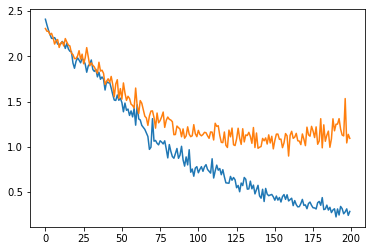

In [313]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [298]:
model.predict_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11092/1514459684.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model.predict_generator(test_generator)


array([[3.0047839e-11, 7.6568228e-13, 5.1486086e-11, ..., 4.5221274e-08,
        1.9529814e-10, 9.2867829e-09],
       [2.2305275e-13, 1.9061590e-16, 1.1657022e-06, ..., 3.8736396e-09,
        1.0870439e-12, 8.4417891e-08],
       [1.0402933e-12, 1.1467331e-30, 5.2197384e-29, ..., 1.8244644e-14,
        5.7433641e-26, 1.0000000e+00],
       ...,
       [2.6672285e-05, 5.6172478e-08, 1.7233944e-04, ..., 2.8345737e-04,
        2.1394249e-03, 1.1044358e-05],
       [1.4841277e-04, 1.3540163e-04, 3.5151382e-07, ..., 4.1227541e-03,
        7.9732209e-02, 8.8816421e-05],
       [2.8468461e-10, 5.4815391e-10, 2.3134300e-08, ..., 1.2128295e-09,
        6.6613191e-09, 6.4442570e-06]], dtype=float32)

In [304]:
np.argmax(model.predict_generator(test_generator)[1])

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11092/362986227.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  np.argmax(model.predict_generator(test_generator)[1])


7

In [305]:
train_generator.class_indices

{'Austria': 0,
 'Belgium': 1,
 'Croatia': 2,
 'Czech Republic': 3,
 'England': 4,
 'France': 5,
 'Germany': 6,
 'Greece': 7,
 'Italy': 8,
 'Portugal': 9,
 'Spain': 10,
 'Switzerland': 11,
 'Turkey': 12}

In [306]:
test_generator.classes

array([ 0,  0,  0, ..., 12, 12, 12])

In [314]:
model.evaluate_generator(validation_generator, steps=5)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11092/3054906762.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator, steps=5)


[1.3722310066223145, 0.6800000071525574]

In [ ]:
# steps per epochs 높여서 돌려보기

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (170, 170, 3), padding = 'same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(13, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 170, 170, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 128)      0

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [20]:
with tf.device('/GPU:0'):
    
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=500,     
        epochs = 120,
        validation_data = validation_generator,
        validation_steps=20      
        )

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_15260/3169287580.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/120
500/500 [==============================] - 146s 286ms/step - loss: 2.2139 - accuracy: 0.2280 - val_loss: 2.1419 - val_accuracy: 0.2580
Epoch 2/120
500/500 [==============================] - 115s 229ms/step - loss: 2.0433 - accuracy: 0.2941 - val_loss: 1.9949 - val_accuracy: 0.3200
Epoch 3/120
500/500 [==============================] - 106s 212ms/step - loss: 1.8709 - accuracy: 0.3651 - val_loss: 1.8137 - val_accuracy: 0.3900
Epoch 4/120
500/500 [==============================] - 103s 205ms/step - loss: 1.6619 - accuracy: 0.4490 - val_loss: 1.5571 - val_accuracy: 0.4940
Epoch 5/120
500/500 [==============================] - 102s 205ms/step - loss: 1.4233 - accuracy: 0.5314 - val_loss: 1.3444 - val_accuracy: 0.5720
Epoch 6/120
500/500 [==============================] - 102s 205ms/step - loss: 1.2747 - accuracy: 0.5850 - val_loss: 1.3451 - val_accuracy: 0.6060
Epoch 7/120
500/500 [==============================] - 103s 206ms/step - loss: 1.1633 - accuracy: 0.6256 - val_loss: 1

500/500 [==============================] - 100s 201ms/step - loss: 0.2310 - accuracy: 0.9266 - val_loss: 1.2710 - val_accuracy: 0.7660
Epoch 112/120
500/500 [==============================] - 101s 201ms/step - loss: 0.2139 - accuracy: 0.9309 - val_loss: 0.8865 - val_accuracy: 0.8260
Epoch 113/120
500/500 [==============================] - 101s 201ms/step - loss: 0.2182 - accuracy: 0.9283 - val_loss: 1.0172 - val_accuracy: 0.7880
Epoch 114/120
500/500 [==============================] - 101s 201ms/step - loss: 0.2070 - accuracy: 0.9343 - val_loss: 0.9568 - val_accuracy: 0.8060
Epoch 115/120
500/500 [==============================] - 101s 202ms/step - loss: 0.2013 - accuracy: 0.9367 - val_loss: 0.9111 - val_accuracy: 0.8300
Epoch 116/120
500/500 [==============================] - 101s 201ms/step - loss: 0.2267 - accuracy: 0.9287 - val_loss: 1.1379 - val_accuracy: 0.7780
Epoch 117/120
500/500 [==============================] - 101s 201ms/step - loss: 0.2155 - accuracy: 0.9306 - val_loss: 1

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from PIL import Image

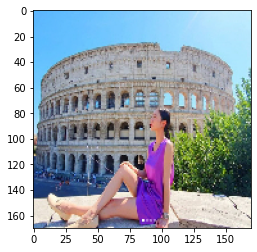

In [22]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\coloseum.jpg'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [23]:
img.shape

(170, 170, 3)

In [24]:
x = np.expand_dims(img, axis = 0)
x.shape

(1, 170, 170, 3)

In [25]:
model.predict(x)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
      dtype=float32)

In [360]:
train_generator.class_indices

{'Austria': 0,
 'Belgium': 1,
 'Croatia': 2,
 'Czech Republic': 3,
 'England': 4,
 'France': 5,
 'Germany': 6,
 'Greece': 7,
 'Italy': 8,
 'Portugal': 9,
 'Spain': 10,
 'Switzerland': 11,
 'Turkey': 12}

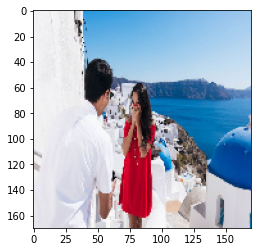

In [26]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\santorini.jpg'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [27]:
y = np.expand_dims(img, axis = 0)
y.shape

(1, 170, 170, 3)

In [28]:
model.predict(y)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)

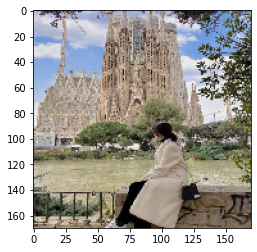

In [29]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\사그.JPG'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [30]:
z = np.expand_dims(img, axis = 0)
z.shape

(1, 170, 170, 3)

In [31]:
model.predict(z)

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.427227e-28, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00]], dtype=float32)

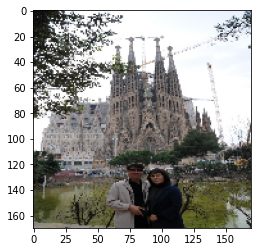

In [32]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\리아.jpg'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [33]:
q = np.expand_dims(img, axis = 0)
q.shape

(1, 170, 170, 3)

In [34]:
model.predict(q)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

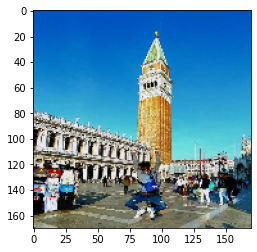

In [35]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\싼마르코.jpg'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [36]:
w = np.expand_dims(img, axis = 0)
w.shape

(1, 170, 170, 3)

In [37]:
train_generator.class_indices

{'Austria': 0,
 'Belgium': 1,
 'Croatia': 2,
 'Czech Republic': 3,
 'England': 4,
 'France': 5,
 'Germany': 6,
 'Greece': 7,
 'Italy': 8,
 'Portugal': 9,
 'Spain': 10,
 'Switzerland': 11,
 'Turkey': 12}

In [39]:
model.predict(w)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
      dtype=float32)

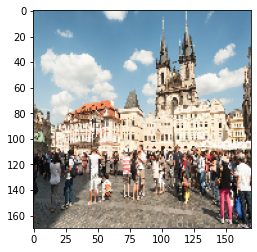

In [43]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\프라하.jpg'

org = load_img(file_name, target_size = (170, 170))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [44]:
e = np.expand_dims(img, axis = 0)
e.shape

(1, 170, 170, 3)

In [45]:
model.predict(e)

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [ ]:
# 모바일넷 돌려보기

In [29]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [30]:
transfer_model = MobileNet(weights='imagenet')
transfer_model.trainable = False
transfer_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [31]:
with tf.device('/GPU:0'):
    finetune_model = Sequential()
    finetune_model.add(transfer_model)
    finetune_model.add(Flatten())
    finetune_model.add(Dense(256, activation = 'relu'))
    finetune_model.add(Dense(128, activation = 'relu'))
    finetune_model.add(Dense(64, activation = 'relu'))
    finetune_model.add(Dense(32, activation = 'relu'))
    finetune_model.add(Dense(13, activation = 'softmax'))
    finetune_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               256256    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                      

In [32]:
finetune_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [33]:

    hist = finetune_model.fit(
        train_generator,
        epochs = 50,
        validation_data = test_generator,
        validation_steps = 20
    )

Epoch 1/50
715/715 [==============================] - 208s 289ms/step - loss: 1.9440 - accuracy: 0.3545 - val_loss: 1.5227 - val_accuracy: 0.5344
Epoch 2/50
715/715 [==============================] - 206s 289ms/step - loss: 1.6592 - accuracy: 0.4644 - val_loss: 1.6498 - val_accuracy: 0.4906
Epoch 3/50
715/715 [==============================] - 208s 290ms/step - loss: 1.5761 - accuracy: 0.4846 - val_loss: 1.6315 - val_accuracy: 0.4750
Epoch 4/50
715/715 [==============================] - 209s 293ms/step - loss: 1.5082 - accuracy: 0.5090 - val_loss: 1.5307 - val_accuracy: 0.5594
Epoch 5/50
715/715 [==============================] - 212s 296ms/step - loss: 1.4521 - accuracy: 0.5322 - val_loss: 1.5213 - val_accuracy: 0.5594
Epoch 6/50
715/715 [==============================] - 213s 298ms/step - loss: 1.3979 - accuracy: 0.5475 - val_loss: 1.3982 - val_accuracy: 0.5250
Epoch 7/50
715/715 [==============================] - 213s 298ms/step - loss: 1.3577 - accuracy: 0.5591 - val_loss: 1.2948 -

In [96]:
from keras.models import load_model

finetune_model.save('mobilenet.h5')

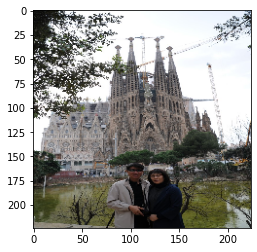

In [28]:
# 사진 test 해보기

file_name = 'D:\B-Project3\B-Project3\data_file\리아.jpg'

org = load_img(file_name, target_size = (224, 224))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [29]:
q = np.expand_dims(img, axis = 0)
q.shape

(1, 224, 224, 3)

In [40]:
pred = finetune_model.predict(q)
pred

array([[0.00663407, 0.00051109, 0.00524129, 0.00287275, 0.04646584,
        0.27306247, 0.11858603, 0.45439294, 0.03557777, 0.00445438,
        0.00888667, 0.02639707, 0.01691769]], dtype=float32)

In [41]:
np.argmax(pred)

7

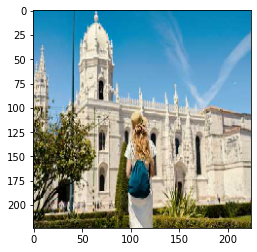

In [75]:
file_name = 'D:\B-Project3\B-Project3\data_file\제로니무스.jpg'

org = load_img(file_name, target_size = (224, 224))
img = img_to_array(org)
plt.imshow(np.uint8(img))

In [76]:
w = np.expand_dims(img, axis = 0)
w.shape

(1, 224, 224, 3)

In [77]:
pred = finetune_model.predict(w)
pred

array([[5.5811042e-04, 1.9557476e-05, 7.2586818e-06, 1.1547552e-05,
        2.2910496e-03, 9.9408060e-01, 1.1772669e-03, 4.1260960e-04,
        8.1549468e-04, 2.7873497e-05, 7.8091936e-05, 1.2466150e-04,
        3.9590543e-04]], dtype=float32)

In [78]:
np.argmax(pred)

5

In [63]:
train_generator.class_indices

{'Austria': 0,
 'Belgium': 1,
 'Croatia': 2,
 'Czech Republic': 3,
 'England': 4,
 'France': 5,
 'Germany': 6,
 'Greece': 7,
 'Italy': 8,
 'Portugal': 9,
 'Spain': 10,
 'Switzerland': 11,
 'Turkey': 12}

In [133]:
# 구글넷 돌려보기

In [31]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate

In [32]:
def inception(x, filters): 
    pre_layer = x
    
    f1,f2,f3,f4 = filters   # filter 갯수

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    
    # 1x1 & 3x3
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w,h,c], c 기준 concatenate (axis = -1 )
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    
    return concat

In [33]:
with tf.device('/GPU:0'):

    input_shape = data_batch[0].shape    
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    #inception (input, [#1x1conv, #3x3conv, #5x5conv, #1x1reduction] )

    # inception 3a
    x = inception(x,[16,36,18,18])
    # inception 3b
    x = inception(x,[48,96,56,56])
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # inception 4a
    x = inception(x,[95,120,60,60])

    aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
    aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
    aux1 = Flatten()(aux1)
    aux1 = Dense(320, activation='relu')(aux1)
    aux1 = Dense(13, activation='softmax')(aux1)

    # inception 4b
    x = inception(x,[120,180,78,78])

    # inception 4c
    x = inception(x,[110,210,89,89])
    # inception 4d
    x = inception(x,[112,288,64,64])
    aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
    aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
    aux2 = Flatten()(aux2)
    aux2 = Dense(220, activation='relu')(aux2)
    aux2 = Dense(13, activation='softmax')(aux2)


    # inception 4e
    x = inception(x,[180,210,186,186])


    # inception 5a
    x = inception(x,[180,210,186,186])
    # inception 5b
    x = inception(x,[220,220,102,102])
    x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    outputs = Dense(13, activation='softmax')(x)


In [34]:
goo_model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

goo_model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy']) 


In [35]:

history = goo_model.fit(train_generator, 
                        validation_data = test_generator,
                        epochs = 10)

Epoch 1/10


NotFoundError: Graph execution error:

Detected at node 'model_1/conv2d_1/Conv2D' defined at (most recent call last):
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bitcamp\AppData\Local\Temp/ipykernel_9172/750609723.py", line 1, in <module>
      history = goo_model.fit(train_generator,
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/conv2d_1/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 338864784 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 338864784 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 739311616 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 739311616 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1865990144 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1865990144 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18007808 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18007808 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 125960192 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 125960192 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 943390720 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 943390720 bytes.
	 [[{{node model_1/conv2d_1/Conv2D}}]] [Op:__inference_train_function_40061]

In [18]:
from tensorflow.keras.applications import EfficientNetB0 
with tf.device('/GPU:0'):
    eff_model = EfficientNetB0(weights=None, input_shape=(224, 224, 3), include_top = False)
    eff_model.trainable = True
    eff_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

In [19]:
efficient_model = Sequential()
efficient_model.add(eff_model)
efficient_model.add(Flatten())

# efficient_model.add(Dense(64, activation = 'relu'))
# efficient_model.add(Dense(32, activation = 'relu'))
efficient_model.add(Dense(13, activation = 'softmax'))
efficient_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 13)                815373    
                                                                 
Total params: 4,864,944
Trainable params: 4,822,921
Non-trainable params: 42,023
_________________________________________________________________


In [24]:
efficient_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
hist = efficient_model.fit(
        train_generator,
        epochs = 50,
        steps_per_epoch= train_generator.samples//train_generator.batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples//validation_generator.batch_size
    )

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block2b_expand_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bitcamp\AppData\Local\Temp/ipykernel_9172/4074921080.py", line 1, in <module>
      hist = res_model.fit(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/block2b_expand_conv/Conv2D'
OOM when allocating tensor with shape[25,144,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block2b_expand_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_32460]